# Python Learn by Doing: Climate Change Indicators and Trend Analysis

**Developed By:** Dr. Kerrie Geil, Mississippi State University

**Original Development Date:** May 2024

**Package Requirements:** xarray, netcdf4, numpy, pandas, scipy, matplotlib, jupyter (and cartopy for one of the Your Turn assignments)

**Hardware requirements:** 100MB available storage on your machine, 8GB RAM

**Links:** **[OSF project link](https://osf.io/zhpd5/)**, [link to this notebook](https://github.com/kerriegeil/MSU_py_training/blob/main/learn_by_doing/climate_change_indicators/climate_change_indicators_AgERA5.ipynb)

**Description:**

This notebook helps the learner build intermediate python programming skills through data query, manipulation, analysis, and visualization. Learning will be centered around computing ETCCDI climate change indices and determining the statistical significance of change. The notebook is aimed at learners who already have intermediate programming skills and some knowledge of statistics. 

-----

# Collection of Useful Links

- all python trainings modules developed by Dr Kerrie Geil can be found in the [OSF MSU_py_training project](https://osf.io/zhpd5/) on the Open Science Framework platform. There you will find links to the most updated versions of the training notebooks on github as well as any required data files.
- [kerrie's github repo](https://github.com/kerriegeil/MSU_py_training) contains python codes but not data files. This repo is linked to the OSF MSU_py_training project above
- [documentation page for every version of Python](https://www.python.org/doc/versions/)
- every version of Python also includes a tutorial e.g. [The Python Tutorial v3.12.3](https://docs.python.org/release/3.12.3/tutorial/index.html)
- this is not technically a link, but Google is your friend! If there is something you want to learn how to do with python, just Google it and click through the search results to see if you can find an answer. A Google search will often return results from online forums like Stack Overflow where someone has asked the same question and received several answers. This same principle works for figuring out conda and jupyter things. Chances are the answer is a quick web search away
- [jupyter markdown cheat sheet](https://notebook.community/tschinz/iPython_Workspace/00_Admin/CheatSheet/Markdown%20CheatSheet)
- [documentation on climate change indicators from the Expert Team on Climate Change Detection and Indices (ETCCDI)](https://etccdi.pacificclimate.org/index.shtml)
- [climdex.org maps and data files](https://www.climdex.org/learn/indices/) for many climate change indices and their trends
- [account registration page](https://cds.climate.copernicus.eu/user/register?destination=%2Fcdsapp%23!%2Fhome) for the [climate data store](https://cds.climate.copernicus.eu/cdsapp#!/home) where you can find tons of free research quality climate data
- [xarray documentation](https://docs.xarray.dev/en/stable/) which includes the api reference, getting started guide, user guide, and developer info

# Introduction to Climate Change Indicators

Climate change indicators (also known as climate change indices) are quantitative measures of some aspect of the climate that can be tracked over time and used to robustly assess climate changes. Good climate change indicators use high quality observational data that is consistent over time (or has been adjusted/homogenized in time<sup>1</sup>) and incorporate statistical methods, if necessary, that reduce the impact of possible data inconsistencies. 

In this notebook we'll look at a few climate change indicators developed by the [Expert Team on Climate Change Detection and Indices (ETCCDI)](https://etccdi.pacificclimate.org/index.shtml) which is a sub-project of [Climate and Ocean Variability, Predictability and Change (CLIVAR)](https://www.clivar.org/), one of the core projects of the [World Climate Research Program's (WCRP)](https://www.wcrp-climate.org/).

The ETCCDI developed a set of [27 core indices](https://etccdi.pacificclimate.org/list_27_indices.shtml) using temperature and precipitation observational data. We'll calculate 5 of these:
- Monthly Maximum Value of Daily Minimum Temperature (TNx)
- Annual Total Precip Amount Over 99th Percentile of Wet Days (R99pTOT)
- Monthly Maximum Consecutive 5-day Precipitation (Rx5day)
- Maximum Length of Consecutive Dry Days (CDD)
- Growing Season Length (GSL)

**Disclaimer:** This notebook is intended for python programming learning only. The data quality checking and calculation of ETCCDI climate change indices in this notebook may differ from the ETCCDI published instructions for simplicity and/or relevance to our learning goals. Learners wanting to compute the indices according to the exact ETCCDI instructions should consult the [ETCCDI documentation](https://etccdi.pacificclimate.org/index.shtml). The documentation suggests using the [RClimDex software package](https://github.com/ECCC-CDAS/RClimDex.git) written in R to calculate ETCCDI climate change indices. Another option would be to use pre-calculated indices based on multiple gridded datasets available at **[climdex.org](https://www.climdex.org/)**, where you can also find a similar software package for calculating the indices on a dataset of your choice.   


Footnotes:
1. Time-dimension inhomogeneities in meteorological observations are due to things like station relocation and changes in instrumentation. For more info, ETCCDI has compiled examples of these inhomogeneities in [Classic Examples of Inhomogeneities in Climate Datasets](https://etccdi.pacificclimate.org/docs/Classic_Examples.pdf)



# Importing Python Packages and Defining Your Workspace


In [1]:
# importing all the python packages we will need here

import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats as ss
import numpy.testing as npt
import os
from urllib.request import urlretrieve
import matplotlib.pyplot as plt

In [2]:
# create a folder for data downloads
if not os.path.exists('./data'):
    os.makedirs('./data')

In [3]:
# filenames to save data to
pr_f='data/prcp_AgERA5_Starkville_Daily_1979-2023.nc'
tmax_f='data/tmax_AgERA5_Starkville_Daily_1979-2023.nc'
tmin_f='data/tmin_AgERA5_Starkville_Daily_1979-2023.nc'

# Obtaining the climate data

For the climate change indices covered in this notebook we will need the following data over many data years:

variable abbrev. | description | frequency | units 
---|---|---|---
tmin | minimum surface air temperature | daily | C 
tmax | maximum surface air temperature | daily | C 
prcp | accummulated precipitation | daily | mm/day 

We'll use the AgERA5 dataset developed by the [European Centre for Medium-range Weather Forecasts (ECMWF)](https://www.ecmwf.int/) available from the [Copernicus Climate Data Store (CDS)](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-agrometeorological-indicators?tab=overview). The data variables in the table above were downloaded from the AgERA5 dataset by the instructor in May 2024, pre-processed, and placed in the [MSU_py_training project on the Open Science Framework (OSF) platform](https://osf.io/zhpd5/). The reason we use OSF to store these files is to guarantee permanent availability of the exact same data files for this training module into the future.

Data file pre-processing includes the following and was completed for you to save time:
1) Using the Climate Data Store (CDS) API to download AgERA5 precipitation and 2m min and max temperature. You need a free CDS account and to install the cdsapi python package as well as python dask to do this. The data downloads as one .tar.gz file per year per variable.
2) Unpacking the .tar.gz files. Each g-zipped archive unpacks to one netcdf file per day per variable (many files).
3) Converting temperature units from K to C
4) Converting longitude coordinates from 0 to 360 to -180 to 180
5) Consolidating all the daily files into one single netcdf file per variable that contains all times.

We won't cover this process in further detail here but if you are interested, the scripts used to pre-process the data are available on Kerrie's github. Step 1-2 is performed in [get_AgERA5_daily_parallel.py](https://github.com/kerriegeil/MSU_py_training/blob/main/learn_by_doing/climate_change_indicators/get_datasets/get_AgERA5_daily_parallel.py) and steps 3-5 are performed in [concat_AgERA5.sh](https://github.com/kerriegeil/MSU_py_training/blob/main/learn_by_doing/climate_change_indicators/get_datasets/concat_AgERA5.sh).

<br>
<font color="green"><b>
**NOTE: You only need to run the following urlretrieve cell once. The data files will then be located on your computer. These files total approximately 4MB in size.**
</b></font> 

In [4]:
# data for Starkville, MS

# precip
url='https://osf.io/aes24/download' # url to the data
urlretrieve(url, pr_f) # download and save data

# tmax
url='https://osf.io/d3hgm/download' # url to the data
urlretrieve(url, tmax_f) # download and save data

# tmin
url='https://osf.io/pjzsx/download' # url to the data
urlretrieve(url, tmin_f) # download and save data

('data/tmin_AgERA5_Starkville_Daily_1979-2023.nc',
 <http.client.HTTPMessage at 0x21ca3175910>)

# Introduction to python xarray 

"Xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw Numpy-like multidimensional arrays, which allows for a more intuitive, more concise, and less error-prone developer experience"

   >-**[xarray documentation](https://docs.xarray.dev/en/stable)**

This package is most powerful when working with multidimensional data in netcdf format and especially with netcdfs that are written using Climate and Forecast Metadata Conventions ([CF Metadata Conventions](https://cfconventions.org)). Xarray can also handle zarr, tiff, csv, hdf, and grib files but may require additional dependencies to be installed. 

Xarray builds upon Numpy, Pandas, Scipy, netCDF4, Matplotlib and more. It also integrates well with Dask for parallel computing. Xarray is under active community development and pushes new updates approximately monthly.

The core data structures used by xarray are called the *DataArray* and the *Dataset*. DataArrays are N-dimensional arrays of a single data variable with dimension, coordinate, and attribute labels. Datasets contain one or more DataArrays that share one or more dimensions and coordinates. Each variable in a Dataset has its own attributes and the Dataset itself can have its own attributes as well (which come from the file attributes in each netcdf). 

Details of all xarray functions (including what parameters to include as function inputs and what each function returns) can be found in the **[xarray API reference](https://docs.xarray.dev/en/stable/api.html)**. Xarray has pretty great documentation with usage examples, definitely check the **[xarray getting started](https://docs.xarray.dev/en/stable/getting-started-guide/index.html)** and **[xarray user guide](https://docs.xarray.dev/en/stable/user-guide/index.html)** documentation for help as you are learning. If you are stuck on something, stack overflow and xarray's issue documentation on github is also useful. I personally often end up at those sites from google searches "python xarray how to ___". 

Let's read in precipitation data from a netcdf file and look at some xarray capabilities.


    

In [5]:
# the netcdf files we're using in this notebook have 1 data variable per file
# read data into a DataArray structure

pr = xr.open_dataarray(pr_f)
pr

<xarray.DataArray 'prcp' (time: 16436, lat: 1, lon: 1)> Size: 66kB
[16436 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 131kB 1979-01-01 1979-01-02 ... 2023-12-31
  * lon      (lon) float64 8B -88.8
  * lat      (lat) float64 8B 33.5
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

With xarray, when we print a variable, instead of getting the values of that variable what we get (usually) is a view of all the metadata labels that are attached to the variable. The information above shows us that our pr data is the daily total precipitation aggregated from midnight to midnight local time each day, has units of mm per day, and is called 'prcp' in the netcdf file.  

We can also see that the data has 3 dimensions (time, lat, lon), the length of each dimension, and that each dimension is a "coordinate", which are essentially additional labels. Click on the paper and data stack icons to the right of each coordinate. Using the paper icon, you can see that each coordinate has its own attributes (standard_name, units, etc.). Using the data stack icon, you can see that each coordinate is also an array of values, similar to an index in Pandas. The beauty of coordinates is that they allow us to easily select a subset of the data variable using labels that correspond to the coordinate values. 

Definitions for xarray terminology such as DataArray, Dataset, variable, dimension, coordinate, attribute can all be found in xarray's user guide on the **[xarray terminology page](https://docs.xarray.dev/en/stable/user-guide/terminology.html)**.

Let's start looking at how to access labels and select/manipulate our data using labels. 

In [6]:
# access the coordinate information (labels/values, attributes) attached to a variable
# same can be done with lon and time
# this is the same info we can see above by clicking on the coordinate icons
pr.lat

<xarray.DataArray 'lat' (lat: 1)> Size: 8B
array([33.5])
Coordinates:
  * lat      (lat) float64 8B 33.5
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

In [7]:
# attributes are always stored as dictionaries which contain items in key:value pairs
# access all the attributes attached to a variable or a coordinate with .attrs

# see dictionary of attributes attached to the variable pr
print(pr.attrs)

# see dictionary of attributes attached to the coordinate lat
pr.lat.attrs

{'long_name': 'Total precipitation (00-00LT)', 'units': 'mm d-1', 'temporal_aggregation': 'Sum 00-00LT', 'standard_name': 'precipitation'}


{'standard_name': 'latitude',
 'long_name': 'latitude',
 'units': 'degrees_north',
 'axis': 'Y'}

Dictionaries are not xarray-specific, they are a python data structure. Here are some good links to more info about dictionaries and other python data structures: **[realpython.com/python-dicts/](https://realpython.com/python-dicts/)** and **[docs.python.org/3/tutorial/datastructures](https://docs.python.org/3/tutorial/datastructures.html#)**

In [8]:
# since attributes are stored in dictionaries we can use dictionary syntax to access the items 

# list all the pr attibutes names (keys) present in the dictionary
print(pr.attrs.keys())

# access the value of the pr 'units' attribute 
print(pr.attrs['units'])

# access the value of the latitude 'units' attribute
pr.lat.attrs['units']

dict_keys(['long_name', 'units', 'temporal_aggregation', 'standard_name'])
mm d-1


'degrees_north'

Now let's start selecting data from the pr array based on its time coordinate labels.

This particular data consists of only 1 data point at lat=33.5, lon=-88.8 (Starkville, MS). We don't need these singleton dimensions so let's remove them. Notice below the singleton dimensions are removed from the variable, but the lat/lon coordinate metadata sticks around in case we need it later (this would be useful, for example, if we wanted to plot the lat/lon location on a map).

In [9]:
# remove singleton dimensions
pr=pr.squeeze()
pr

<xarray.DataArray 'prcp' (time: 16436)> Size: 66kB
[16436 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 131kB 1979-01-01 1979-01-02 ... 2023-12-31
    lon      float64 8B -88.8
    lat      float64 8B 33.5
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

In [10]:
# select data for 1 May 1982
pr.sel(time='1982-05-01')

<xarray.DataArray 'prcp' ()> Size: 4B
[1 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 1982-05-01
    lon      float64 8B -88.8
    lat      float64 8B 33.5
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

In [11]:
# select data for all of 2020
pr.sel(time=slice('2020-01-01','2020-12-31'))

<xarray.DataArray 'prcp' (time: 366)> Size: 1kB
[366 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
    lon      float64 8B -88.8
    lat      float64 8B 33.5
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

what if we want to see the data value but not the extra metadata labels on a particular day?


In [12]:
# .data on an xarray object will return the underlying numpy array of data without labels
pr.sel(time='1982-05-01').data

array(0.27938843, dtype=float32)

In [13]:
# add data from multiple days together
# sum all precip in 2020
pr.sel(time=slice('2020-01-01','2020-12-31')).sum()

<xarray.DataArray 'prcp' ()> Size: 4B
array(1613.13, dtype=float32)
Coordinates:
    lon      float64 8B -88.8
    lat      float64 8B 33.5

What if we want to select data from the array based on some sort of criteria? .where is a great solution

Important to note that xarray.where and xarray.DataArray.where are different. Here we're using **[xarray.DataArray.where](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.where.html)**. We'll cover **[xarray.where](https://docs.xarray.dev/en/stable/generated/xarray.where.html)** later

In [14]:
# selecting with .where
# find pr > 3 inches/day (3 inches/day * 2.54 cm/inch * 10 mm/cm = 76.2 mm/day)

# select pr where greater than 76.2 and drop all other days from the array
pr.where(pr>76.2,drop=True)

<xarray.DataArray 'prcp' (time: 14)> Size: 56B
array([ 94.68631 ,  97.42238 , 107.88191 , 181.73953 ,  95.31076 ,
       103.79834 , 102.18793 , 111.15207 , 167.39362 ,  81.7865  ,
        79.77347 ,  82.977875, 104.58713 ,  87.718765], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 112B 1982-12-04 1990-12-22 ... 2022-08-24
    lon      float64 8B -88.8
    lat      float64 8B 33.5
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

In [15]:
# if you don't drop=True xarray keeps the data dimensions 
# and automatically fills the days that don't meet the criteria with nan
pr.where(pr>76.2)

<xarray.DataArray 'prcp' (time: 16436)> Size: 66kB
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 131kB 1979-01-01 1979-01-02 ... 2023-12-31
    lon      float64 8B -88.8
    lat      float64 8B 33.5
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

In [16]:
# do the same thing but return the dates that meet the criteria, not the pr values
times_heavy=pr.where(pr>76.2,drop=True).time
times_heavy

<xarray.DataArray 'time' (time: 14)> Size: 112B
array(['1982-12-04T00:00:00.000000000', '1990-12-22T00:00:00.000000000',
       '1992-08-27T00:00:00.000000000', '1993-05-25T00:00:00.000000000',
       '1995-08-04T00:00:00.000000000', '2002-09-26T00:00:00.000000000',
       '2004-02-05T00:00:00.000000000', '2005-08-29T00:00:00.000000000',
       '2011-09-05T00:00:00.000000000', '2012-09-30T00:00:00.000000000',
       '2013-09-21T00:00:00.000000000', '2015-11-18T00:00:00.000000000',
       '2021-08-30T00:00:00.000000000', '2022-08-24T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 112B 1982-12-04 1990-12-22 ... 2022-08-24
    lon      float64 8B -88.8
    lat      float64 8B 33.5
Attributes:
    standard_name:  time
    axis:           T

In [17]:
# you can also select from a DataArray using a list or array of labels
# select from pr with an array of time labels
pr.sel(time=times_heavy)

<xarray.DataArray 'prcp' (time: 14)> Size: 56B
array([ 94.68631 ,  97.42238 , 107.88191 , 181.73953 ,  95.31076 , 103.79834 ,
       102.18793 , 111.15207 , 167.39362 ,  81.7865  ,  79.77347 ,  82.977875,
       104.58713 ,  87.718765], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 112B 1982-12-04 1990-12-22 ... 2022-08-24
    lon      float64 8B -88.8
    lat      float64 8B 33.5
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

If the time coordinate is datetime objects like we have here, we can do some real fancy stuff. Xarray implements a lot of the useful features from pandas with the **[xarray .dt datetime accessor](https://docs.xarray.dev/en/latest/generated/xarray.core.accessor_dt.DatetimeAccessor.html)**.

In [18]:
pr.time

<xarray.DataArray 'time' (time: 16436)> Size: 131kB
array(['1979-01-01T00:00:00.000000000', '1979-01-02T00:00:00.000000000',
       '1979-01-03T00:00:00.000000000', ..., '2023-12-29T00:00:00.000000000',
       '2023-12-30T00:00:00.000000000', '2023-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 131kB 1979-01-01 1979-01-02 ... 2023-12-31
    lon      float64 8B -88.8
    lat      float64 8B 33.5
Attributes:
    standard_name:  time
    axis:           T

In [19]:
pr.time.dt.day

<xarray.DataArray 'day' (time: 16436)> Size: 131kB
array([ 1,  2,  3, ..., 29, 30, 31], dtype=int64)
Coordinates:
  * time     (time) datetime64[ns] 131kB 1979-01-01 1979-01-02 ... 2023-12-31
    lon      float64 8B -88.8
    lat      float64 8B 33.5
Attributes:
    standard_name:  time
    axis:           T

In [20]:
pr.time.dt.isocalendar()

<xarray.Dataset> Size: 526kB
Dimensions:  (time: 16436)
Coordinates:
  * time     (time) datetime64[ns] 131kB 1979-01-01 1979-01-02 ... 2023-12-31
    lon      float64 8B -88.8
    lat      float64 8B 33.5
Data variables:
    year     (time) int64 131kB 1979 1979 1979 1979 1979 ... 2023 2023 2023 2023
    week     (time) int64 131kB 1 1 1 1 1 1 1 2 2 ... 51 51 52 52 52 52 52 52 52
    weekday  (time) int64 131kB 1 2 3 4 5 6 7 1 2 3 4 ... 4 5 6 7 1 2 3 4 5 6 7

**[xarray .dt datetime accessor](https://docs.xarray.dev/en/latest/generated/xarray.core.accessor_dt.DatetimeAccessor.html)** is very helpful when used in combination with **[xarray.DataArray.resample](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.resample.html)** or **[xarray.DataArray.groupby](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html)** to easily resample or group your data, which we'll get to here shortly 

You can find all the different methods (e.g. .sum(), .mean(), etc) that are possible to use on xarray resample and groupby objects here: **[xarray.core.resample.DataArrayResample](https://docs.xarray.dev/en/latest/generated/xarray.core.resample.DataArrayResample.html#xarray.core.resample.DataArrayResample)** and **[xarray.core.groupby.DataArrayGroupBy](https://docs.xarray.dev/en/latest/generated/xarray.core.groupby.DataArrayGroupBy.html)**

In [21]:
# resample to annual sum 
# and make the time coordinate label the last day of the year 
# (YE = year end)
pr_annual = pr.resample(time='YE').sum()
pr_annual

<xarray.DataArray 'prcp' (time: 45)> Size: 180B
array([1590.7233 , 1358.4116 ,  981.3751 , 1559.0004 , 1599.9998 ,
       1264.7771 , 1086.916  , 1139.1315 , 1205.4623 , 1043.1216 ,
       1484.4932 , 1352.093  , 1575.6547 , 1319.3586 , 1516.521  ,
       1537.2427 , 1470.0647 , 1314.1826 , 1409.3127 , 1344.082  ,
        979.8386 , 1064.1064 , 1585.0288 , 1383.2832 , 1296.9692 ,
       1651.7386 , 1292.7786 , 1139.2625 ,  960.22626, 1302.3755 ,
       1789.438  , 1073.112  , 1250.8994 , 1366.398  , 1451.2905 ,
       1138.6627 , 1322.2102 , 1030.4275 , 1275.1545 , 1549.2471 ,
       1648.7151 , 1613.13   , 1457.8884 , 1341.5841 , 1311.3562 ],
      dtype=float32)
Coordinates:
    lon      float64 8B -88.8
    lat      float64 8B 33.5
  * time     (time) datetime64[ns] 360B 1979-12-31 1980-12-31 ... 2023-12-31
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

In this case some of our variable attributes may no longer make sense. Sometimes this happens when we operate on our data with certain functions (like resample). Or sometimes, functions that aggregate or reduce your data will actually delete coordinates and variable attributes to avoid leaving metadata that is no longer accurate. In these situations, we manually update or add new metadata labels in cases where they get deleted entirely.

When and why would we want to update coordinates or variable attributes like standard_name, units, etc? 

Every little bit of metadata (like attributes) that are attached to your variables don't need to be 100% accurate and up to date at all times. But, it becomes important to update this info in at least 2 situations: 
1) if you use a package for plotting that automatically places labels on figures based on the variable attributes and coordinate labels/values present (xarray plotting does this) or 
2) if you write a variable out to a new netcdf file you'll want to make sure all the metadata attached to your variable is correct (good data management)  

In [22]:
# modifying attributes

# replace a variable attribute value
pr_annual.attrs['units']='mm/year'

# delete a whole variable attribute
del pr_annual.attrs['temporal_aggregation']

# knock the last 10 characters off a variable attribute
pr_annual.attrs['long_name']=pr_annual.attrs['long_name'][:-10]

# look at our new attributes
pr_annual

<xarray.DataArray 'prcp' (time: 45)> Size: 180B
array([1590.7233 , 1358.4116 ,  981.3751 , 1559.0004 , 1599.9998 ,
       1264.7771 , 1086.916  , 1139.1315 , 1205.4623 , 1043.1216 ,
       1484.4932 , 1352.093  , 1575.6547 , 1319.3586 , 1516.521  ,
       1537.2427 , 1470.0647 , 1314.1826 , 1409.3127 , 1344.082  ,
        979.8386 , 1064.1064 , 1585.0288 , 1383.2832 , 1296.9692 ,
       1651.7386 , 1292.7786 , 1139.2625 ,  960.22626, 1302.3755 ,
       1789.438  , 1073.112  , 1250.8994 , 1366.398  , 1451.2905 ,
       1138.6627 , 1322.2102 , 1030.4275 , 1275.1545 , 1549.2471 ,
       1648.7151 , 1613.13   , 1457.8884 , 1341.5841 , 1311.3562 ],
      dtype=float32)
Coordinates:
    lon      float64 8B -88.8
    lat      float64 8B 33.5
  * time     (time) datetime64[ns] 360B 1979-12-31 1980-12-31 ... 2023-12-31
Attributes:
    long_name:      Total precipitation
    units:          mm/year
    standard_name:  precipitation

In [23]:
# another resample example
# resample to seasonal mean
# 'QS' means make the time label for each season at the start of the season (quarter start)
# 'JAN' means make start the seasonal aggregates with January: JFM, AMJ, JAS, OND
pr.resample(time='QS-JAN').sum()

<xarray.DataArray 'prcp' (time: 180)> Size: 720B
array([435.29163 , 395.64734 , 468.82315 , 290.96124 , 523.224   ,
       410.26422 , 205.07549 , 219.84796 , 289.27686 , 254.06154 ,
       193.6872  , 244.34955 , 380.80853 , 393.50305 , 297.92117 ,
       486.76755 , 429.52362 , 665.7711  , 157.22266 , 347.48236 ,
       328.7078  , 395.96768 , 250.29854 , 289.8032  , 277.17432 ,
       236.7661  , 314.11572 , 258.86    , 187.69707 , 330.09656 ,
       202.7337  , 418.6042  , 488.912   , 256.6909  , 233.0029  ,
       226.85648 , 262.8283  , 175.93936 , 325.1914  , 279.1626  ,
       308.75034 , 507.85925 , 414.14276 , 253.74069 , 560.5677  ,
       217.78589 , 204.77113 , 368.9682  , 541.218   , 499.61023 ,
       262.45074 , 272.37567 , 339.15912 , 253.29724 , 406.58353 ,
       320.31876 , 396.00876 , 584.5846  , 251.2435  , 284.6841  ,
       420.47723 , 368.8699  , 359.88138 , 388.0142  , 410.93793 ,
       291.79968 , 343.51398 , 423.81308 , 326.80997 , 257.7096  ,
       376.158   , 353.50513 , 401.3332  , 462.5046  , 273.8715  ,
       271.60355 , 464.70648 , 280.10767 , 345.22305 , 254.04489 ,
       417.87268 , 262.54095 , 123.074844, 176.35008 , 323.0302  ,
       339.5535  , 111.0379  , 290.48474 , 496.92294 , 332.56137 ,
       392.2539  , 363.29053 , 353.86655 , 234.81044 , 377.73584 ,
       416.87042 , 301.74982 , 442.87555 , 315.84937 , 236.49448 ,
       414.63538 , 507.81012 , 274.35602 , 454.93707 , 319.88348 ,
       356.33978 , 409.4921  , 207.06311 , 414.7586  , 165.96489 ,
       155.53833 , 403.00064 , 217.20224 , 162.95758 , 338.00916 ,
       242.05727 , 257.63553 , 318.6756  , 388.42523 , 337.6391  ,
       460.70496 , 345.0258  , 451.98752 , 531.7197  , 338.11566 ,
       270.0837  , 178.55249 , 286.36017 , 343.0209  , 258.8434  ,
       411.72714 , 237.3079  , 416.78003 , 221.97609 , 454.5593  ,
       273.08243 , 471.444   , 342.9142  , 360.58774 , 276.3445  ,
       321.43622 , 344.96826 , 221.19588 , 251.0624  , 376.59326 ,
       325.68454 , 192.86548 , 427.06686 , 409.1714  , 237.2917  ,
       162.73601 , 221.22842 , 334.07324 , 435.5957  , 299.4576  ,
       206.02798 , 414.77505 , 366.61865 , 325.88184 , 441.9716  ,
       470.2115  , 456.32584 , 287.46957 , 434.70813 , 697.37177 ,
       411.26688 , 224.41675 , 280.07465 , 395.9923  , 437.23077 ,
       475.85657 , 148.80873 , 459.19302 , 229.85587 , 426.6728  ,
       225.86244 , 460.46686 , 490.93356 , 206.31586 , 153.63986 ],
      dtype=float32)
Coordinates:
    lon      float64 8B -88.8
    lat      float64 8B 33.5
  * time     (time) datetime64[ns] 1kB 1979-01-01 1979-04-01 ... 2023-10-01
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

.resample and .groupby can be used to easily calculate anomalies

Let's make monthly pr anomalies. We calculate monthly mean pr and subtract the monthly long term mean (climatology) pr.

This means, for example, Jan 1979 mean pr - Jan (1979-2023) mean pr, Feb 1979 mean pr - Feb (1979-2023) mean pr, and so on for each monthly data point

In [24]:
# first we need mean the monthly mean pr values, use .resample
pr_monthly=pr.resample(time='MS').mean()
pr_monthly

<xarray.DataArray 'prcp' (time: 540)> Size: 2kB
array([ 6.5726357 ,  5.1153345 ,  2.8487277 ,  8.32765   ,  3.4824588 ,
        1.2620534 ,  7.549866  ,  2.8399851 ,  4.891258  ,  1.7835014 ,
        5.11803   ,  2.6494122 ,  4.3101983 ,  2.4757075 , 10.25201   ,
        6.0451202 ,  5.1146145 ,  2.345252  ,  2.416974  ,  0.73578376,
        3.5779998 ,  2.4797816 ,  3.867486  ,  0.8693597 ,  1.6022117 ,
        3.364641  ,  4.69027   ,  2.0752075 ,  3.5704517 ,  2.7040436 ,
        2.0278828 ,  2.227731  ,  2.0587723 ,  2.8590648 ,  2.7264965 ,
        2.3846338 ,  6.021074  ,  4.090919  ,  2.5680492 ,  7.2611585 ,
        1.4938138 ,  4.312002  ,  4.5219755 ,  3.4753034 ,  1.6668508 ,
        2.9520957 ,  4.9583592 ,  7.951671  ,  3.2955983 ,  6.7750545 ,
        4.4405985 ,  8.690541  ,  8.779146  ,  4.4300456 ,  1.6046034 ,
        1.4384195 ,  2.0962982 ,  2.6875787 ,  3.6037414 ,  5.0340376 ,
        2.3644867 ,  3.1171596 ,  5.3229384 ,  6.396239  ,  5.2489896 ,
        1.3787283 ,  1.9385632 ,  5.274176  ,  0.89012045,  4.1225443 ,
        4.0334625 ,  1.3225944 ,  3.103172  ,  3.706506  ,  2.4901235 ,
        2.057955  ,  3.6295595 ,  2.0837035 ,  3.6205485 ,  3.2049565 ,
        3.4175012 ,  5.4424777 ,  0.9879008 ,  1.9518113 ,  0.81714505,
        2.238992  ,  3.2152839 ,  1.000767  ,  5.6402025 ,  4.1742415 ,
        1.0541047 ,  2.662671  ,  2.917122  ,  4.8975396 ,  5.4469686 ,
        3.3345609 ,  4.159383  ,  8.310062  ,  4.106108  ,  1.1314127 ,
...
        4.912589  ,  5.831035  ,  3.07515   ,  2.2078445 ,  2.5531342 ,
        2.8217    ,  1.7487911 ,  0.7016927 ,  0.36921543,  3.0704916 ,
        3.7957418 ,  5.470573  ,  3.247266  ,  2.3729687 ,  3.7078161 ,
        5.0854583 ,  5.5570674 ,  1.711155  ,  6.757109  ,  1.2313807 ,
        2.0125053 ,  1.6671234 ,  3.0202134 ,  1.8826308 ,  8.421866  ,
        3.8903623 ,  5.1344624 ,  3.663485  ,  3.3005579 ,  3.354975  ,
        2.673801  ,  4.6329923 ,  2.119058  ,  5.1248784 ,  7.1785307 ,
        5.768482  ,  7.366346  ,  2.7461557 ,  6.9450955 ,  4.05973   ,
        4.0707116 ,  3.6849537 ,  5.5405445 ,  0.0493042 ,  7.573717  ,
        2.4745228 ,  4.0544267 ,  6.0502276 ,  8.978318  ,  8.046562  ,
        6.8360915 ,  3.1405487 ,  3.6275706 ,  2.0498834 ,  1.9176242 ,
        3.3808005 ,  2.945737  ,  1.5734533 ,  4.5662327 ,  2.5126495 ,
        3.9914415 ,  6.656123  ,  3.4454386 ,  4.0000906 ,  6.9954934 ,
        5.0056825 ,  7.391633  ,  3.0513256 ,  1.5796863 ,  0.9952901 ,
        2.2574112 ,  3.8789632 ,  6.770943  ,  4.8180246 ,  3.1017137 ,
        3.0483098 ,  1.4102285 ,  4.3640056 ,  7.1136003 ,  2.362233  ,
        1.110549  ,  3.1110275 ,  3.1646645 ,  5.576061  ,  5.039626  ,
        4.7257886 ,  8.407896  ,  1.7954386 ,  6.1012697 ,  5.099771  ,
        0.70927674,  0.87451273,  0.40976837,  2.0176911 ,  2.593752  ],
      dtype=float32)
Coordinates:
    lon      float64 8B -88.8
    lat      float64 8B 33.5
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2023-12-01
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

We'll use **[xarray.DataArray.groupby](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html)** for the rest of the calculation. Before we proceed, let's take a look at .groupby. If you are familiar with Pandas, this will look very similar since xarray .groupby is based on Pandas .groupby

In [25]:
# .groupby returns an object that can be iterated over in the form (label,grouped_data) pairs
pr_monthly.groupby(pr_monthly.time.dt.month)

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

if we think in terms of xarray dimensions and coordinates, this is similar to getting a new dimension named month that is also a coordinate with values/labels 1-12 

In [26]:
# how to access the group labels (dictionary-like syntax)
pr_monthly.groupby(pr_monthly.time.dt.month).groups.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

In [27]:
# how to access the group of data assigned to a label (dictionary-like syntax)
# the following shows the data associated with label (month) 5
label=5
pr_monthly.groupby(pr_monthly.time.dt.month)[label]

<xarray.DataArray 'prcp' (time: 45)> Size: 180B
array([ 3.4824588,  5.1146145,  3.5704517,  1.4938138,  8.779146 ,
        5.2489896,  3.6295595,  5.6402025,  3.5760212,  1.9655919,
        6.6312094,  2.6170812,  8.169278 ,  1.387524 , 11.256011 ,
        3.2823436,  2.933547 ,  1.0702647,  5.1442986,  2.4763386,
        3.3658354,  1.4508721,  3.5444748,  2.8529718,  5.458647 ,
        5.8419013,  2.908893 ,  1.9011934,  0.8847351,  4.2447314,
        7.055287 ,  4.6844444,  1.9038357,  3.8251584,  3.9242904,
        2.2097   ,  3.2698905,  2.2078445,  5.0854583,  3.663485 ,
        4.05973  ,  3.1405487,  4.0000906,  3.0483098,  1.7954386],
      dtype=float32)
Coordinates:
    lon      float64 8B -88.8
    lat      float64 8B 33.5
  * time     (time) datetime64[ns] 360B 1979-05-01 1980-05-01 ... 2023-05-01
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

If you look at all the time labels (data stack icon for the time coordinate) you'll see this group is all the May data values in the pr_monthly timeseries. 45 years worth of May values. We can calculate the long term May mean pr by taking the mean of this group of data

In [28]:
pr_monthly.groupby(pr_monthly.time.dt.month)[label].mean()

<xarray.DataArray 'prcp' ()> Size: 4B
array(3.8621447, dtype=float32)
Coordinates:
    lon      float64 8B -88.8
    lat      float64 8B 33.5

We can calculate the long term mean for each month of the year (the groups) by excluding the [label] part from above. The value of the 5th number in the returned array below should be the same as above. Notice also below the new dimension and coordinate named 'month' and its coordinate labels 1-12. 

In [29]:
pr_monthly.groupby(pr_monthly.time.dt.month).mean()

<xarray.DataArray 'prcp' (month: 12)> Size: 48B
array([4.0294294, 4.6782117, 4.3714337, 4.1760316, 3.8621447, 3.3423753,
       3.5212684, 3.1881328, 3.0313714, 2.78087  , 3.248168 , 3.9518824],
      dtype=float32)
Coordinates:
    lon      float64 8B -88.8
    lat      float64 8B 33.5
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

These new labels from .groupby are what makes .groupby so "smart" when we actually compute the anomalies. We'll be taking each monthly mean pr value in the timeseries and subtracting the appropriate long term mean value, all without any loops to slow us down.

In [30]:
# calculate anomalies, putting it all together

# the first term is 12 groups (months) each containing 45 data values (1 value per year)
# the second term is 12 groups (months) each containing 1 value (long term monthly mean) 

# based on the labels present, for each group .groupby is smart enough to broadcast 
# the 1 value in the second term to each of the 45 values in the first term
# in other words, the appropriate long term mean value is subtracted from every monthly data value in the time series
# no loops (or nested loops) needed

pr_anom= pr_monthly.groupby(pr_monthly.time.dt.month) - pr_monthly.groupby(pr_monthly.time.dt.month).mean()
pr_anom

<xarray.DataArray 'prcp' (time: 540)> Size: 2kB
array([ 2.54320621e+00,  4.37122822e-01, -1.52270603e+00,  4.15161848e+00,
       -3.79685879e-01, -2.08032179e+00,  4.02859783e+00, -3.48147631e-01,
        1.85988641e+00, -9.97368574e-01,  1.86986208e+00, -1.30247021e+00,
        2.80768871e-01, -2.20250416e+00,  5.88057661e+00,  1.86908865e+00,
        1.25246978e+00, -9.97123241e-01, -1.10429430e+00, -2.45234895e+00,
        5.46628475e-01, -3.01088333e-01,  6.19318008e-01, -3.08252263e+00,
       -2.42721772e+00, -1.31357074e+00,  3.18836212e-01, -2.10082412e+00,
       -2.91692972e-01, -6.38331652e-01, -1.49338555e+00, -9.60401773e-01,
       -9.72599030e-01,  7.81948566e-02, -5.21671534e-01, -1.56724858e+00,
        1.99164438e+00, -5.87292671e-01, -1.80338454e+00,  3.08512688e+00,
       -2.36833096e+00,  9.69626904e-01,  1.00070715e+00,  2.87170649e-01,
       -1.36452055e+00,  1.71225786e-01,  1.71019125e+00,  3.99978876e+00,
       -7.33831167e-01,  2.09684277e+00,  6.91647530e-02,  4.51450968e+00,
        4.91700172e+00,  1.08767033e+00, -1.91666496e+00, -1.74971330e+00,
       -9.35073137e-01, -9.32912827e-02,  3.55573416e-01,  1.08215523e+00,
       -1.66494274e+00, -1.56105208e+00,  9.51504707e-01,  2.22020721e+00,
        1.38684487e+00, -1.96364701e+00, -1.58270514e+00,  2.08604336e+00,
       -2.14125085e+00,  1.34167433e+00,  7.85294533e-01, -2.62928796e+00,
       -9.26257372e-01, -9.71705675e-01, -1.88131022e+00, -2.11807656e+00,
       -2.32585192e-01, -1.25867176e+00,  9.92801189e-02,  1.68237686e-02,
...
       -1.79999065e+00, -7.68364668e-01, -1.58104455e+00, -9.31668997e-01,
       -2.14679861e+00,  3.74365473e+00, -4.81071472e-01,  9.58430767e-01,
       -1.98659658e-01, -4.18174267e-02, -1.66293383e-01, -5.14331818e-01,
        1.60162091e+00, -6.61812067e-01,  1.87671041e+00,  3.22664833e+00,
        1.73905277e+00,  2.68813419e+00, -1.62527800e+00,  2.76906395e+00,
        1.97585344e-01,  7.28336334e-01,  1.63685322e-01,  2.35241175e+00,
       -2.98206711e+00,  4.79284716e+00, -7.73645163e-01,  1.02544308e-01,
        2.02079821e+00,  4.30010653e+00,  3.67512846e+00,  2.66005993e+00,
       -7.21596003e-01,  2.85195351e-01, -1.47138500e+00, -1.27050853e+00,
        3.49429131e-01,  1.64866924e-01, -1.67471468e+00,  6.14350319e-01,
       -1.51677990e+00, -6.86770201e-01,  2.28468943e+00, -7.30592966e-01,
        1.37945890e-01,  3.65311813e+00,  1.48441410e+00,  4.20350027e+00,
        1.99542046e-02, -1.20118368e+00, -2.25287795e+00, -1.69447112e+00,
       -1.50466204e-01,  2.09273148e+00,  4.46590900e-01, -1.07431793e+00,
       -8.13834906e-01, -1.93214679e+00,  8.42737198e-01,  3.92546749e+00,
       -6.69138432e-01, -1.67032099e+00, -1.37140512e-01, -7.87217855e-01,
        1.54663134e+00,  3.61414433e-01,  3.54354858e-01,  4.23186445e+00,
       -2.06670618e+00,  2.75889444e+00,  1.57850266e+00, -2.47885609e+00,
       -2.15685868e+00, -2.37110162e+00, -1.23047686e+00, -1.35813046e+00],
      dtype=float32)
Coordinates:
    lon      (time) float64 4kB -88.8 -88.8 -88.8 -88.8 ... -88.8 -88.8 -88.8
    lat      (time) float64 4kB 33.5 33.5 33.5 33.5 33.5 ... 33.5 33.5 33.5 33.5
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2023-12-01
    month    (time) int64 4kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

Now, we'll make a quick figure of our pr daily timeseries and our monthly pr anomalies. 

Here's a link to **[xarray plotting basics](https://docs.xarray.dev/en/latest/user-guide/plotting.html)** 

Xarray plotting is based on matplotlib. here are some useful links: **[matplotlib documentation](https://matplotlib.org/stable/index.html)** and **[short matplotlib tutorial](https://matplotlib.org/stable/tutorials/pyplot.html)** and **[matplotlib api reference](https://matplotlib.org/stable/api/index.html)**

Remember, at the beginning of this notebook we imported matplotlib.pyplot as plt, so that's where plt is coming from below

We are using a combination of xarray plotting (**[xr.DataArray.plot](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.plot.html)**) and **[matplotlib.pyplot](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html)** which work seamlessly together

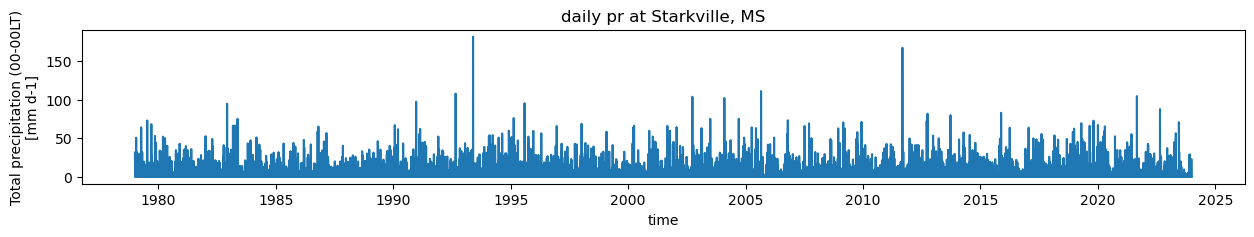

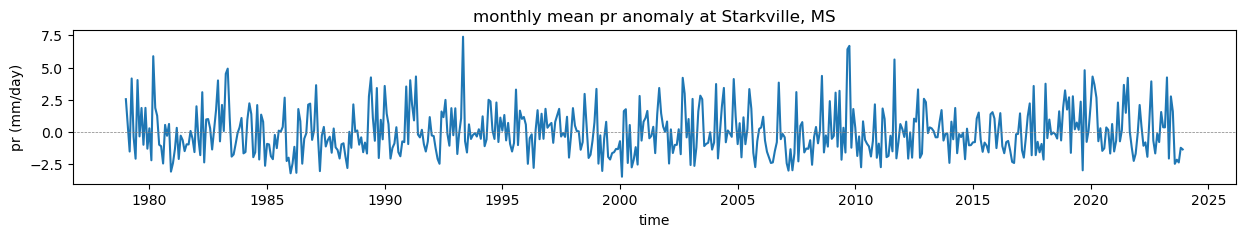

In [31]:
# plotting

fig=plt.figure(figsize=(15,2))
pr.plot()
plt.title('daily pr at Starkville, MS')
plt.show()

fig=plt.figure(figsize=(15,2))
pr_anom.plot()
plt.axhline(y=0,color='grey',linestyle='dashed',linewidth=0.5)
plt.title('monthly mean pr anomaly at Starkville, MS')
plt.ylabel('pr (mm/day)')
plt.show()

Thus far we've been working with data in xarray's DataArray structure. We opened our data file with **[xarray.open_dataarray](https://docs.xarray.dev/en/latest/generated/xarray.open_dataarray.html)** 

Sometimes there are multiple variables in a netcdf file as well as file attributes that we need (different from variable or coordinate attributes). In this situation you would read the data file into an xarray Dataset (instead of a Data Array) using **[xarray.open_dataset](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html)**. 

This doesn't really apply to us here since our data files only have 1 variable each and we don't need the file attributes, but we'll go through an example of how to read data into a Dataset below anyway.

In [32]:
# .open_dataset instead of .open_dataarray
ds = xr.open_dataset(pr_f)
ds

<xarray.Dataset> Size: 197kB
Dimensions:  (time: 16436, lon: 1, lat: 1)
Coordinates:
  * time     (time) datetime64[ns] 131kB 1979-01-01 1979-01-02 ... 2023-12-31
  * lon      (lon) float64 8B -88.8
  * lat      (lat) float64 8B 33.5
Data variables:
    prcp     (time, lat, lon) float32 66kB ...
Attributes:
    history:  Thu Apr  4 14:19:41 2024: ncatted -O -a,global,d,, /work/hpc/us...
    NCO:      netCDF Operators version 5.2.2 (Homepage = http://nco.sf.net, C...

Notice you can now see the file attributes called 'history' and 'NCO' (sometimes also called global attributes). If this file had more than one variable they would appear in the Data variables section under prcp.

Similar to how you can access coordinate information from a data variable with varname.coordname, you can access the data variables in a dataset with dataset.varname like below 

In [33]:
pr=ds.prcp
pr

<xarray.DataArray 'prcp' (time: 16436, lat: 1, lon: 1)> Size: 66kB
[16436 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 131kB 1979-01-01 1979-01-02 ... 2023-12-31
  * lon      (lon) float64 8B -88.8
  * lat      (lat) float64 8B 33.5
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

# Data Cleaning

The minimum quality control procedures suggested by ETCCDI are as follows.

Replace data value with Nan for:
- user-defined missing values (i.e -9999-->Nan)
- daily precip values less than 0
- daily max temperature less than daily minimum temperature
- daily temperature greater than 70C (158F) or less than -70C (-94F)
- leap days (i.e Feb 29th)
- impossible dates (i.e. 32nd March, 12th June 2042)
- non-numeric values
- daily temperature outliers (i.e. 3-5 times the standard deviation from the mean value for each calendar day)


Addressing each of these items below...

In [34]:
# first let's start with a fresh read of all the data we'll be using
pr = xr.open_dataarray(pr_f)
tx = xr.open_dataarray(tmax_f)
tn = xr.open_dataarray(tmin_f)

pr=pr.squeeze()
tx=tx.squeeze()
tn=tn.squeeze()
pr

<xarray.DataArray 'prcp' (time: 16436)> Size: 66kB
[16436 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 131kB 1979-01-01 1979-01-02 ... 2023-12-31
    lon      float64 8B -88.8
    lat      float64 8B 33.5
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

### nan for user-defined missing values (i.e -9999-->Nan)

xr.open_dataset does this for you. 


Notice in the variable attributes above there is no _FillValue=-9999., which the value stored for missing data in the netcdf. This is because xarray automatically replaces the _FillValue with nan.

### how much data is missing to begin with?

before we move on to the rest of the data cleaning, it's usually a good idea to get acquainted with how many missing data values there are

We'll do a quick look here and then look deeper later


In [35]:
print('total of',pr.isnull().sum().data,'missing pr values')
print('total of',tx.isnull().sum().data,'missing tx values')
print('total of',tn.isnull().sum().data,'missing tn values')

total of 0 missing pr values
total of 1 missing tx values
total of 0 missing tn values


Good news! We don't really have to worry about missing data since there is only 1 day missing in one of our data variables

### nan for daily precip values less than 0

In [36]:
# are there any negatives?
(pr<0).data.sum()

0

### nan for daily max temperature less than daily minimum temperature

In [37]:
# is tx ever less than tn?
(tx<tn).data.sum()



0

In [38]:
# # if there were any tx<tn this is how we would fix it
# # where tx<tn fill both tx and tn with nan
# tx=xr.where(tx<tn,np.nan,tx)
# tn=xr.where(tx<tn,np.nan,tn)

# # is tx ever less than tn now?
# (tn>tx).data.sum()

### nan for daily temperature greater than 70C (158F) or less than -70C (-94F)

In [39]:
# is tx>70C, tx<-70C, tn>70C, or tn<-70C?
((tx>70)|(tx<-70)).data.sum(), ((tn>70)|(tn<-70)).data.sum()

(0, 0)

### leap days (i.e Feb 29th)

To make our lives easier later on instead of filling leap days with nan, we'll drop leap days from the timeseries entirely. 

First let's double check that the time dimension is the same for all of our data arrays 

More information on using python assert and numpy.testing for code debugging: **[realpython.com/python-assert-statement](https://realpython.com/python-assert-statement/)** and **[numpy.testing API reference](https://numpy.org/doc/stable/reference/routines.testing.html)**


In [40]:
# check time dims are all the same
assert list(pr.time.data)==list(tx.time.data), 'pr.time and tx.time are not equal'
assert list(pr.time.data)==list(tn.time.data), 'pr.time and tn.time are not equal'

# another way to do the same thing without having to convert data structure is with numpy.testing
npt.assert_array_equal(pr.time,tx.time,'npt error: pr.time and tx.time are not equal')
npt.assert_array_equal(pr.time,tn.time,'npt error: pr.time and tn.time are not equal')

Notice we're now using **[xarray.where](https://docs.xarray.dev/en/stable/generated/xarray.where.html)** (a core function of the xarray package) below which accepts different parameters than **[xarray.DataArray.where](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.where.html)** (a method that operates on an xarray data array object) that we used earlier 

In [41]:
# create a boolean array of dim 'time' where leap days are True and all other days are False
isleapday=xr.where((pr.time.dt.day==29) & (pr.time.dt.month==2),True,False)
isleapday

<xarray.DataArray (time: 16436)> Size: 16kB
array([False, False, False, ..., False, False, False])
Coordinates:
  * time     (time) datetime64[ns] 131kB 1979-01-01 1979-01-02 ... 2023-12-31
    lon      float64 8B -88.8
    lat      float64 8B 33.5

In [42]:
# how many leap days are there?
isleapday.data.sum()

11

In [43]:
# drop leap days from each data variable
pr=pr.where(~isleapday,drop=True)  # ~ means not (where isleapday is not True)
tx=tx.where(isleapday!=True,drop=True)  # !=True is another way to do the same thing 
tn=tn.where(isleapday==False,drop=True)  # ==False is a third way of doing the same thing

pr  # should be 11 days shorter

<xarray.DataArray 'prcp' (time: 16425)> Size: 66kB
array([31.362183  ,  0.        ,  0.        , ...,  0.21365356,
        0.        ,  0.        ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 131kB 1979-01-01 1979-01-02 ... 2023-12-31
    lon      float64 8B -88.8
    lat      float64 8B 33.5
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

### nan for impossible dates (i.e. 32nd March, 12th June 2042)

This data has datetimes for the time dimension. If there were impossible dates, xarray would have had a problem at the open_dataarray statement. So we know there are no impossible dates present.

Missing dates, on the other hand, would not throw an error. But we can check if there are missing dates just by looking at the length of the time dimension. We have 45 years of daily data, now without leap days. 

45years * 365days = 16425days

In [44]:
len(pr), len(tx), len(tn)

(16425, 16425, 16425)

### nan for non-numeric values

Similarly, use of netcdf and xarray ensures that there are no non-numeric values or mixed numeric data types per variable. Each variable in the data file is of one data type (e.g. float) and if there were a non-float value present there would have been an error already. We can be assured the data we've read is all float. For more on data types: **[data types tutorial](https://realpython.com/python-data-types/)** and **[min/max values of different data types](https://jakevdp.github.io/PythonDataScienceHandbook/02.01-understanding-data-types.html#NumPy-Standard-Data-Types)**

In [45]:
pr.dtype, tx.dtype, tn.dtype

(dtype('float32'), dtype('float32'), dtype('float32'))

### daily temperature outliers (i.e. 3-5 times the standard deviation from the mean value for each calendar day)

We'll use 5x standard deviation to identify outliers

Using .dt.dayofyear here might seem tempting to calculate the standard dev for each day for example tx.groupby(tx.time.dt.dayofyear).mean('time'), but it's going to give you the wrong results! Let's take a look at why

Use .groupby with .dt.dayofyear and look at the data for day of year group 60 and day of year group 61

.dt.dayofyear determines the day of year specific to each year, so in leap years day 60 will be 29 Feb and in non-leap years 1 Mar

Similarly, in leap years day 61 will be 1 Mar but in non-leap years 2 Mar, and so on for every day of the year >= 60

In some cases, maybe this is desirable, but in our case we want the day of year to be 1-365 regardless of leap year or non-leap year

In [46]:
# what data is in the dayofyear 60 group?
tx.groupby(tx.time.dt.dayofyear)[60] # only 34 march 1st?

<xarray.DataArray 'tmax' (time: 34)> Size: 136B
array([17.181437 , 15.247971 , 15.669302 , 19.034966 , 11.9522505,
        7.61569  , 12.766605 , 10.293566 , 12.078816 , 16.994917 ,
       15.905781 , 13.589285 , 10.79317  , 26.4724   , 12.058832 ,
       19.99587  , 15.827511 , 10.283574 , 13.924021 ,  7.820528 ,
       23.263279 , 21.213238 ,  7.1926928, 11.51926  , 16.76843  ,
        6.781352 , 19.358044 , 13.589285 , 22.36066  , 18.651936 ,
       11.892298 , 18.268908 , 19.05495  , 25.569782 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 272B 1979-03-01 1981-03-01 ... 2023-03-01
    lon      float64 8B -88.8
    lat      float64 8B 33.5
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [47]:
# what data is in the dayofyear 61 group?
tx.groupby(tx.time.dt.dayofyear)[61] # mix of mar 1 and mar 2?

<xarray.DataArray 'tmax' (time: 45)> Size: 180B
array([19.724419 ,  6.31339  , 15.014822 , 18.910065 , 23.108402 ,
       11.356057 , 15.456139 , 17.193094 , 14.808319 , 16.996582 ,
       11.502607 , 13.983973 , 23.637981 , 20.950113 , 14.966526 ,
        9.334327 , 10.02045  ,  6.303398 , 22.402294 , 10.355184 ,
       21.441391 , 22.991827 , 13.484369 , 14.268747 , 10.844795 ,
       21.431398 , 10.963035 , 23.138378 , 17.153126 , 19.213158 ,
        6.7547064,  7.2842865, 19.929256 , 24.13925  ,  3.800383 ,
       23.324896 , 11.610854 , 21.832747 , 14.268747 , 15.750904 ,
       14.858278 , 18.860106 , 10.698245 , 22.540518 , 20.45051  ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 360B 1979-03-02 1980-03-01 ... 2023-03-02
    lon      float64 8B -88.8
    lat      float64 8B 33.5
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [48]:
tx.groupby(tx.time.dt.dayofyear).count()

<xarray.DataArray 'tmax' (dayofyear: 366)> Size: 1kB
array([45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 34, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 44, 45, 11])
Coordinates:
    lon        float64 8B -88.8
    lat        float64 8B 33.5
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [49]:
# code we could have used to double checked ourselves

# is there data from only 1 date (e.g. all 1 Mar) in each group?
ndates=[]
for label,group in tx.groupby(tx.time.dt.dayofyear):
    ndates.append(len(np.unique(group.time.dt.day)))
print('groups contain',np.unique(ndates),'dates, expected 1')

# do all groups have the same number of days?
print('groups have',np.unique(tx.groupby(tx.time.dt.dayofyear).count()),'numbers, expected 45')

groups contain [1 2] dates, expected 1
groups have [11 34 44 45] numbers, expected 45


Sometimes things that are supposed to make our lives easier, just don't work out. 

We need to write a new coordinate with values 1-365 (we'll call it doy) and then use .groupby with this new index so we can ignore leap days entirely, we should get 45 march 1st, 45 march 2nd, etc for every date (and no leap days because we've dropped them)

In [50]:
# create a list 16425 numbers long where day of the year without leap days (1-365) is repeated 45 times
doy=list(range(1,366))*45
doy[363:367],len(doy)

([364, 365, 1, 2], 16425)

In [51]:
tx.coords['doy']=('time',doy)
tn.coords['doy']=('time',doy)
tx

<xarray.DataArray 'tmax' (time: 16425)> Size: 66kB
array([17.367954 , -0.5678189,  1.4688993, ...,  8.485001 , 10.0820675,
       15.89912  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 131kB 1979-01-01 1979-01-02 ... 2023-12-31
    lon      float64 8B -88.8
    lat      float64 8B 33.5
    doy      (time) int32 66kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [52]:
# is there data from only 1 date (e.g. all 1 Mar) in each group?
ndates=[]
for label,group in tx.groupby(tx.doy):
    ndates.append(len(np.unique(group.doy)))
print('tx groups contain',np.unique(ndates),'dates, expected 1')

ndates=[]
for label,group in tn.groupby(tn.doy):
    ndates.append(len(np.unique(group.doy)))
print('tn groups contain',np.unique(ndates),'dates, expected 1')

# do all groups have the same number of days?
print('tx groups have',np.unique(tx.groupby(tx.doy).count()),'numbers, expected 45')
print('tn groups have',np.unique(tn.groupby(tn.doy).count()),'numbers, expected 45')

tx groups contain [1] dates, expected 1
tn groups contain [1] dates, expected 1
tx groups have [44 45] numbers, expected 45
tn groups have [45] numbers, expected 45


In [53]:
# find the long term mean for each day of the year
tx_daily_mean=tx.groupby(tx.doy).mean()
tn_daily_mean=tn.groupby(tn.doy).mean()
tx_daily_mean

<xarray.DataArray 'tmax' (doy: 365)> Size: 1kB
array([12.027081 , 11.174386 , 10.803903 , 11.320382 , 10.836358 ,
       11.425187 , 11.025986 ,  9.864721 , 11.071616 , 11.51086  ,
       11.608634 , 11.548942 , 11.401392 , 11.122094 , 10.739694 ,
       10.35078  , 11.1303835, 11.558452 , 11.242924 , 11.08072  ,
       10.672821 , 11.131642 , 11.279192 , 11.779646 , 12.1889515,
       11.489396 , 11.689088 , 12.414181 , 13.118842 , 12.643406 ,
       12.771896 , 13.309137 , 12.180143 , 12.288467 , 11.421821 ,
       10.662051 , 10.94072  , 12.06679  , 12.537083 , 12.640149 ,
       12.833442 , 12.591817 , 11.840858 , 12.377433 , 14.621244 ,
       15.130396 , 14.9814415, 13.482444 , 13.968576 , 14.8303385,
       16.52429  , 17.147501 , 16.246548 , 16.989143 , 16.147106 ,
       14.639749 , 14.669392 , 15.244824 , 16.262869 , 15.808412 ,
       15.92325  , 15.608424 , 16.464155 , 17.056683 , 16.863985 ,
       17.241722 , 17.308596 , 17.72763  , 17.403372 , 17.491932 ,
       17.76808  , 17.82226  , 18.23375  , 18.45735  , 18.153109 ,
       19.591118 , 19.951313 , 18.850075 , 18.582916 , 18.069733 ,
       18.454575 , 19.506851 , 20.30481  , 19.72849  , 19.807354 ,
       20.397108 , 21.004477 , 20.857815 , 20.3668   , 20.072107 ,
       20.891603 , 21.381622 , 22.043764 , 21.018875 , 20.94571  ,
       20.833279 , 20.889162 , 21.097143 , 21.31253  , 22.648134 ,
...
       27.310257 , 26.425545 , 26.468256 , 26.762169 , 26.846249 ,
       26.504374 , 26.794033 , 26.529875 , 26.122417 , 24.660246 ,
       24.988428 , 24.995941 , 24.721235 , 24.409445 , 24.542152 ,
       24.350307 , 24.297642 , 24.47184  , 23.479551 , 23.382107 ,
       22.951488 , 22.340382 , 22.789915 , 23.377153 , 22.74084  ,
       22.309479 , 21.674242 , 21.095259 , 21.749    , 21.484726 ,
       21.259014 , 21.34654  , 21.63768  , 21.537498 , 20.704865 ,
       19.878332 , 19.670534 , 19.417849 , 19.124931 , 18.924831 ,
       19.044958 , 19.261082 , 19.318996 , 18.8191   , 18.590576 ,
       16.850475 , 16.402275 , 17.216297 , 17.18632  , 16.879677 ,
       17.050282 , 16.817057 , 17.128775 , 17.075113 , 16.462341 ,
       16.122684 , 15.925949 , 15.625261 , 16.299358 , 16.45098  ,
       16.205061 , 15.287755 , 14.916306 , 15.571234 , 14.903169 ,
       14.898136 , 15.086284 , 14.368076 , 13.970315 , 13.30314  ,
       12.79721  , 13.795714 , 14.600965 , 13.641505 , 12.872705 ,
       12.672085 , 12.986171 , 13.078803 , 13.580922 , 12.976991 ,
       12.305082 , 12.185361 , 11.286631 , 11.926012 , 12.927773 ,
       13.404431 , 11.992923 , 11.273159 ,  9.724684 , 11.294364 ,
       12.9689245, 13.1176605, 12.1982765, 12.168443 , 12.907307 ],
      dtype=float32)
Coordinates:
    lon      float64 8B -88.8
    lat      float64 8B 33.5
  * doy      (doy) int32 1kB 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [54]:
# find the standard deviation for each day of the year
tx_stddev=tx.groupby(tx.doy).std()
tn_stddev=tn.groupby(tn.doy).std()
tx_stddev

<xarray.DataArray 'tmax' (doy: 365)> Size: 1kB
array([5.4912786, 6.216916 , 6.7524047, 6.305629 , 4.9125943, 5.619153 ,
       6.193696 , 6.1184273, 5.370817 , 6.001833 , 6.3976464, 6.3937063,
       5.704127 , 5.1726866, 4.653944 , 5.4454875, 5.9743557, 5.412213 ,
       5.64786  , 6.1651807, 6.097004 , 4.659649 , 5.2527986, 4.619986 ,
       4.8716145, 4.9906917, 4.4617677, 4.9259896, 5.476677 , 4.798872 ,
       4.993502 , 6.1828604, 6.5739326, 6.143897 , 5.5068216, 5.44991  ,
       6.2139606, 5.8218255, 5.7252374, 5.5949054, 5.7201066, 5.6797523,
       5.946364 , 5.058682 , 4.824379 , 6.0953703, 5.1641164, 5.252982 ,
       5.551655 , 5.443916 , 5.340279 , 4.234038 , 5.0452924, 5.687961 ,
       4.746169 , 4.7564015, 5.736369 , 5.609914 , 5.1042733, 5.4087586,
       5.7183046, 5.260144 , 4.931367 , 4.3950686, 5.5137715, 4.780619 ,
       5.250412 , 4.978272 , 5.4060726, 5.109602 , 5.449273 , 5.11899  ,
       5.279988 , 4.7346563, 4.3313594, 4.4694657, 4.210113 , 5.3245   ,
       5.5246716, 4.705831 , 4.960464 , 4.515741 , 3.7826555, 4.4408526,
       5.5319867, 4.6537166, 4.7203283, 4.2047644, 4.4617944, 4.148296 ,
       3.8603582, 4.2132897, 4.6385984, 4.7632136, 4.288616 , 4.459109 ,
       4.9762435, 4.169742 , 4.5392857, 4.1020303, 3.4406674, 3.4341295,
       3.8992937, 4.4426923, 4.673692 , 3.9878957, 3.9431083, 4.020942 ,
       4.643554 , 3.6499007, 4.35049  , 4.0688276, 4.526609 , 3.7810218,
       3.1785514, 3.9082856, 3.7831771, 3.675767 , 3.218281 , 3.6644368,
...
       2.5239305, 2.382168 , 3.2807   , 2.9767916, 2.782414 , 3.4074771,
       3.7288742, 3.1592748, 3.0619292, 3.20334  , 3.2857656, 3.4598439,
       3.8054967, 3.8084888, 3.8184862, 4.038698 , 3.2734   , 3.393326 ,
       3.3906622, 3.6502028, 3.8047848, 3.9402387, 3.712879 , 4.034349 ,
       3.8898125, 4.058617 , 3.7945354, 4.1232696, 4.1138053, 3.891378 ,
       3.754292 , 2.9790192, 3.6381907, 3.461782 , 3.38121  , 3.6721547,
       3.9584239, 4.069197 , 4.105172 , 4.3730707, 4.093358 , 3.488173 ,
       3.3456569, 3.658501 , 4.126326 , 4.6358066, 4.231662 , 4.3711047,
       4.72329  , 4.4308863, 4.1518683, 4.4593163, 4.4186325, 4.5719414,
       5.1683526, 4.669388 , 4.4645276, 4.348037 , 4.5085196, 4.945643 ,
       4.081999 , 3.9365356, 3.983717 , 4.7205   , 5.1408234, 5.7592826,
       5.106884 , 4.6590037, 5.142826 , 5.0673003, 4.3406606, 4.233726 ,
       4.5442796, 3.99641  , 3.8934166, 4.2038436, 4.1987567, 4.662651 ,
       5.2202616, 4.783096 , 4.3957524, 4.5022073, 4.42144  , 4.797456 ,
       5.126406 , 4.956663 , 5.5227056, 5.539641 , 5.12642  , 5.1531515,
       5.4069934, 5.182903 , 5.4278383, 5.33548  , 4.8512964, 5.073681 ,
       4.661478 , 5.139202 , 5.484676 , 4.930997 , 5.8280807, 5.842975 ,
       5.232943 , 5.9892316, 6.610468 , 7.19405  , 6.5671763, 5.5182104,
       5.394757 , 4.991871 , 5.2946076, 5.9582925, 5.3635764],
      dtype=float32)
Coordinates:
    lon      float64 8B -88.8
    lat      float64 8B 33.5
  * doy      (doy) int32 1kB 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [55]:
# define daily outlier temperature as exceeding the mean +/- 5 times standard deviation
tx_outlier_upper, tx_outlier_lower=(tx_daily_mean+tx_stddev*5), (tx_daily_mean-tx_stddev*5)
tn_outlier_upper, tn_outlier_lower=(tn_daily_mean+tn_stddev*5), (tn_daily_mean-tn_stddev*5)
tx_outlier_upper

<xarray.DataArray 'tmax' (doy: 365)> Size: 1kB
array([39.483475, 42.258965, 44.565926, 42.848526, 35.39933 , 39.52095 ,
       41.994465, 40.456856, 37.9257  , 41.520027, 43.596867, 43.517475,
       39.922028, 36.985527, 34.009415, 37.578217, 41.002163, 38.619514,
       39.482224, 41.906624, 41.15784 , 34.429886, 37.543182, 34.879578,
       36.547024, 36.442856, 33.997925, 37.04413 , 40.502228, 36.637764,
       37.739407, 44.223442, 45.049805, 43.007954, 38.95593 , 37.911602,
       42.01052 , 41.17592 , 41.16327 , 40.614677, 41.433975, 40.990578,
       41.572678, 37.67084 , 38.74314 , 45.607246, 40.802025, 39.747356,
       41.726852, 42.04992 , 43.225685, 38.317688, 41.473007, 45.428947,
       39.877953, 38.421757, 43.35124 , 43.29439 , 41.784233, 42.852203,
       44.51477 , 41.909145, 41.120987, 39.03203 , 44.432842, 41.144817,
       43.560654, 42.618988, 44.433735, 43.03994 , 45.014442, 43.41721 ,
       44.63369 , 42.13063 , 39.809906, 41.938446, 41.001877, 45.472576,
       46.206276, 41.59889 , 43.256897, 42.085556, 39.218086, 41.932755,
       47.467285, 43.66569 , 44.606117, 41.881638, 42.675774, 40.813587,
       40.193398, 42.44807 , 45.236755, 44.834946, 42.38879 , 43.128822,
       45.77038 , 41.945854, 44.008957, 43.158287, 39.545715, 39.25434 ,
       42.0868  , 44.499477, 45.076492, 42.129944, 42.809658, 43.130882,
       46.444412, 42.241203, 45.664734, 44.13955 , 46.14039 , 42.9786  ,
       40.283882, 43.435097, 43.281067, 43.34439 , 41.557495, 43.631577,
...
       43.241985, 42.586983, 46.60176 , 44.985   , 43.958893, 46.589867,
       48.021023, 45.064705, 44.884735, 45.432213, 45.611298, 46.102028,
       47.71975 , 47.15458 , 46.708775, 47.63553 , 43.655163, 44.265266,
       44.26357 , 44.67656 , 45.49218 , 46.463364, 45.410645, 46.676117,
       46.243095, 46.82296 , 45.095093, 45.276596, 45.557457, 44.45283 ,
       43.492695, 39.304543, 42.73311 , 41.659218, 41.20369 , 42.83261 ,
       43.27167 , 43.728092, 43.47735 , 44.205734, 43.256706, 40.818016,
       39.469124, 40.601982, 42.30587 , 44.274292, 42.90731 , 43.34025 ,
       44.875465, 43.50097 , 42.397022, 43.83408 , 42.798027, 42.738037,
       45.5123  , 42.764786, 41.44757 , 40.665016, 41.587555, 43.989296,
       39.72899 , 38.501778, 38.509163, 40.452976, 42.10639 , 46.01271 ,
       42.72074 , 40.174698, 42.764412, 42.153557, 38.832077, 38.243744,
       39.18374 , 36.104736, 35.393032, 36.644478, 37.293144, 39.764236,
       42.306366, 39.203236, 36.895065, 38.082268, 37.01037 , 38.885414,
       40.718315, 39.15139 , 41.583843, 41.001343, 38.42931 , 39.561474,
       41.635933, 39.55602 , 40.011894, 39.349487, 37.242653, 38.44721 ,
       36.888313, 38.673   , 39.728462, 36.840343, 40.427032, 41.14089 ,
       39.092487, 43.35059 , 45.04526 , 47.24341 , 42.560562, 38.885418,
       39.942707, 38.077015, 38.671314, 41.959904, 39.72519 ],
      dtype=float32)
Coordinates:
    lon      float64 8B -88.8
    lat      float64 8B 33.5
  * doy      (doy) int32 1kB 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365

In [56]:
# are there any outliers?
print('tx',(tx.groupby(tx.doy)>tx_outlier_upper).data.sum(), (tx.groupby(tx.doy)<tx_outlier_lower).data.sum())
print('tn',(tn.groupby(tn.doy)>tn_outlier_upper).data.sum(), (tn.groupby(tn.doy)<tn_outlier_lower).data.sum())

tx 0 0
tn 0 0


Out of all the data cleaning steps above, the only step that resulted in a change to the original data arrays was dropping leap days. This likely would not hold true for AgERA5 data at other locations (e.g. not Starkville) or, of course, for data from other sources.

### another look at nans

We already know that tx is the only data variable with a missing data point. But if we had more missing data, it would be helpful to know how many nans per month there are since many of our climate change indicators group data by month. We'll write a custom function to do this.

more on writing functions here: **[realpython.com/defining-your-own-python-function](https://realpython.com/defining-your-own-python-function/)**

more on pandas MultiIndexing here: **[pandas MultiIndex and advanced indexing](https://pandas.pydata.org/docs/user_guide/advanced.html)**

In [57]:
# a function that sums the number of nans in each month of data
def get_nans_per_month(data_in):
    month_groups=pd.MultiIndex.from_arrays([data_in.time['time.year'].data,data_in.time['time.month'].data])
    data_in.coords['month_groups']=('time',month_groups)    
    nancount=data_in.isnull().groupby('month_groups').sum()
    return nancount

In [58]:
# call our function
nan_per_month=get_nans_per_month(tx.copy())
nan_per_month

<xarray.DataArray 'tmax' (month_groups: 540)> Size: 2kB
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Coordinates:
    lon           float64 8B -88.8
    lat           float64 8B 33.5
  * month_groups  (month_groups) object 4kB MultiIndex
  * time_level_0  (month_groups) int64 4kB 1979 1979 1979 ... 2023 2023 2023
  * time_level_1  (month_groups) int64 4kB 1 2 3 4 5 6 7 8 ... 6 7 8 9 10 11 12

we can see the one missing data point we were expecting

Let's plot nan_per_month. While we're at it, we'll make a proper datetime array for the x-axis values with **[pandas.date_range](https://pandas.pydata.org/docs/reference/api/pandas.date_range.html)**

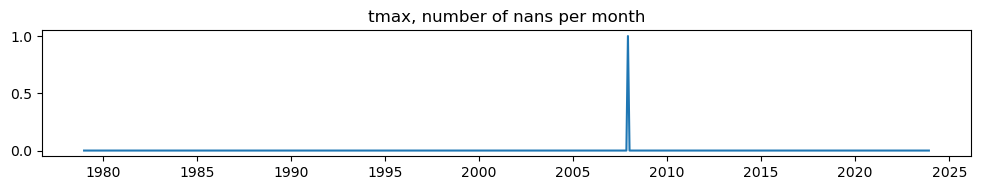

In [59]:
# plot it

# create datetimes for the x axis
# MS means month start for the monthly time labels e.g. 1979-01-01, 1979-02-01
# if we used ME instead (month end) we'd get time labels like 1979-01-31, 1979-02-28
# either is ok, MS is a personal preference
time_months=pd.date_range(tx.time.data[0],tx.time.data[-1],freq='MS')

# plot
fig=plt.figure(figsize=(10,2))
plt.plot(time_months,nan_per_month)
plt.title('tmax, number of nans per month')
plt.tight_layout()
plt.show()

and which specific day is it when we are missing data?

In [60]:
tx.where(tx.isnull(),drop=True).time

<xarray.DataArray 'time' (time: 1)> Size: 8B
array(['2007-12-30T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 8B 2007-12-30
    lon      float64 8B -88.8
    lat      float64 8B 33.5
    doy      (time) int32 4B 364
Attributes:
    standard_name:  time
    axis:           T

# Calculate climate change indicators

### Monthly Maximum Value of Daily Minimum Temperature (TNx)

- max(each month of daily minimum temperature values)

Here we are inputting daily data and pulling out 1 value per month.

In [61]:
# create coordinate labels that we can use to group data in every month of the timeseries

# this is similar to how we found nans per month
# create an index for every month in the timeseries so we can use .groupby with it later
month_groups=pd.MultiIndex.from_arrays([tn.time['time.year'].data,tn.time['time.month'].data])

# add the month_groups index as a new coordinate 
# the month_groups coordinate will allow us to groupby every month 
# each day of data in any particular month will be associated with a label in the month_groups coordinate
tn.coords['month_groups']=('time',month_groups)    
tn

<xarray.DataArray 'tmin' (time: 16425)> Size: 66kB
array([ -1.0973482,  -8.009786 , -10.3461895, ...,   1.0852547,
        -1.8058729,   1.3012676], dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 131kB 1979-01-01 ... 2023-12-31
    lon           float64 8B -88.8
    lat           float64 8B 33.5
    doy           (time) int32 66kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
    month_groups  (time) object 131kB (1979, 1) (1979, 1) ... (2023, 12)
Attributes:
    long_name:             Minimum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Min 00-00LT
    units:                 degrees_C
    standard_name:         2m_min_air_temperature

In [62]:
# now groupby month and find the maximum value of each month
# this should return 1 value for every month, 45 years x 12 months = length 540
TNx=tn.groupby('month_groups').max()
TNx

<xarray.DataArray 'tmin' (month_groups: 540)> Size: 2kB
array([ 7.149189 , 15.696419 , 17.327755 , 18.195263 , 20.149757 ,
       23.05989  , 24.1054   , 23.452171 , 22.083511 , 18.259205 ,
       12.190084 , 14.446995 , 12.164164 , 13.572573 , 13.161282 ,
       14.604254 , 20.232704 , 24.352516 , 27.293758 , 25.34618  ,
       24.90033  , 20.199871 , 13.954485 , 10.982136 ,  8.104834 ,
       12.684324 , 14.711395 , 18.267845 , 20.7304   , 24.096756 ,
       26.13247  , 25.27533  , 22.65897  , 19.714272 , 15.136509 ,
       13.360014 , 15.022455 , 12.502872 , 19.646877 , 18.115772 ,
       23.262081 , 22.84388  , 24.01381  , 24.364616 , 23.324291 ,
       21.404362 , 16.458515 , 18.92971  , 10.398035 , 10.710823 ,
       13.835245 , 16.767845 , 19.612312 , 22.363464 , 25.72118  ,
       25.648602 , 22.881897 , 18.874413 , 14.643999 , 14.766695 ,
        3.592741 , 13.413586 , 15.257477 , 20.307014 , 20.821991 ,
       23.184315 , 24.504593 , 22.289154 , 21.8554   , 20.291462 ,
       18.981556 , 16.201027 ,  6.5408955, 12.784554 , 19.069687 ,
       18.65667  , 22.883625 , 24.032818 , 24.11404  , 24.077747 ,
       23.70102  , 20.006325 , 19.002293 , 11.04262  ,  8.48329  ,
       13.990774 , 17.542038 , 16.93029  , 20.084087 , 23.542034 ,
       25.904362 , 26.374405 , 22.73328  , 23.60252  , 20.661278 ,
       12.101952 ,  7.9078293, 10.672804 , 12.827757 , 17.663006 ,
...
       14.917042 , 17.396877 , 18.872684 , 21.33524  , 24.978092 ,
       25.755741 , 25.109428 , 25.169914 , 21.808743 , 18.0069   ,
       16.702179 , 16.048954 , 14.887663 , 17.815079 , 21.732704 ,
       21.539154 , 23.07026  , 25.63823  , 23.979248 , 21.796642 ,
       23.177402 , 19.800678 , 13.287434 , 14.951603 , 18.114044 ,
       17.448723 , 16.672798 , 22.216576 , 24.762081 , 25.496525 ,
       24.831203 , 23.59042  , 22.77821  , 15.98674  , 13.7211895,
       10.061054 , 18.190079 , 16.328907 , 17.84446  , 22.985584 ,
       24.547794 , 24.699867 , 25.375557 , 24.473484 , 24.94526  ,
       12.9349   , 13.576029 , 16.121532 , 14.046074 , 18.98674  ,
       19.608856 , 20.872105 , 24.444107 , 24.552979 , 24.8433   ,
       25.149178 , 19.209663 , 17.224068 , 11.319117 , 14.811626 ,
       18.713696 , 17.652637 , 18.768997 , 20.38132  , 23.479824 ,
       25.031666 , 24.846756 , 22.474064 , 21.26957  , 12.525337 ,
       18.260933 , 19.175102 , 16.187202 , 16.902637 , 18.442383 ,
       22.665882 , 25.33754  , 26.583508 , 23.585236 , 22.46024  ,
       16.214851 , 17.953327 , 17.493652 , 16.857708 , 17.920494 ,
       18.378445 , 19.258053 , 20.068535 , 23.224064 , 25.114613 ,
       26.353668 , 23.52821  , 19.65379  , 15.79665  , 13.465429 ],
      dtype=float32)
Coordinates:
    lon           float64 8B -88.8
    lat           float64 8B 33.5
  * month_groups  (month_groups) object 4kB MultiIndex
  * time_level_0  (month_groups) int64 4kB 1979 1979 1979 ... 2023 2023 2023
  * time_level_1  (month_groups) int64 4kB 1 2 3 4 5 6 7 8 ... 6 7 8 9 10 11 12
Attributes:
    long_name:             Minimum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Min 00-00LT
    units:                 degrees_C
    standard_name:         2m_min_air_temperature

Notice we lose the original 'time' coordinate containing datetimes. This is because we have reduced our data array with .groupby().max(), and the original daily datetimes no longer apply, so xarray deletes the old time coordinate that no longer makes sense.

If we want, we can write a new time coordinate with monthly datetimes where the label would be the first day of each month (e.g. 1979-01-01). If you remember, we've already made these exact monthly datetimes earlier 'time_months'. We'll use time_months to write a new time coordinate to our TNx data array. We don't have to do this, but it will make plotting a figure easier.

In [63]:
# change the month_groups dim name and coordinate labels to datetimes
TNx=TNx.rename({'month_groups':'time'})  # renaming a coordinate and dimension
TNx=TNx.drop_vars(['time_level_0','time_level_1']) # deleting leftovers from MultiIndex that we don't need
TNx.coords['time']=('time',time_months) # assign datetimes as the coordinate values/labels 
TNx

<xarray.DataArray 'tmin' (time: 540)> Size: 2kB
array([ 7.149189 , 15.696419 , 17.327755 , 18.195263 , 20.149757 ,
       23.05989  , 24.1054   , 23.452171 , 22.083511 , 18.259205 ,
       12.190084 , 14.446995 , 12.164164 , 13.572573 , 13.161282 ,
       14.604254 , 20.232704 , 24.352516 , 27.293758 , 25.34618  ,
       24.90033  , 20.199871 , 13.954485 , 10.982136 ,  8.104834 ,
       12.684324 , 14.711395 , 18.267845 , 20.7304   , 24.096756 ,
       26.13247  , 25.27533  , 22.65897  , 19.714272 , 15.136509 ,
       13.360014 , 15.022455 , 12.502872 , 19.646877 , 18.115772 ,
       23.262081 , 22.84388  , 24.01381  , 24.364616 , 23.324291 ,
       21.404362 , 16.458515 , 18.92971  , 10.398035 , 10.710823 ,
       13.835245 , 16.767845 , 19.612312 , 22.363464 , 25.72118  ,
       25.648602 , 22.881897 , 18.874413 , 14.643999 , 14.766695 ,
        3.592741 , 13.413586 , 15.257477 , 20.307014 , 20.821991 ,
       23.184315 , 24.504593 , 22.289154 , 21.8554   , 20.291462 ,
       18.981556 , 16.201027 ,  6.5408955, 12.784554 , 19.069687 ,
       18.65667  , 22.883625 , 24.032818 , 24.11404  , 24.077747 ,
       23.70102  , 20.006325 , 19.002293 , 11.04262  ,  8.48329  ,
       13.990774 , 17.542038 , 16.93029  , 20.084087 , 23.542034 ,
       25.904362 , 26.374405 , 22.73328  , 23.60252  , 20.661278 ,
       12.101952 ,  7.9078293, 10.672804 , 12.827757 , 17.663006 ,
...
       14.917042 , 17.396877 , 18.872684 , 21.33524  , 24.978092 ,
       25.755741 , 25.109428 , 25.169914 , 21.808743 , 18.0069   ,
       16.702179 , 16.048954 , 14.887663 , 17.815079 , 21.732704 ,
       21.539154 , 23.07026  , 25.63823  , 23.979248 , 21.796642 ,
       23.177402 , 19.800678 , 13.287434 , 14.951603 , 18.114044 ,
       17.448723 , 16.672798 , 22.216576 , 24.762081 , 25.496525 ,
       24.831203 , 23.59042  , 22.77821  , 15.98674  , 13.7211895,
       10.061054 , 18.190079 , 16.328907 , 17.84446  , 22.985584 ,
       24.547794 , 24.699867 , 25.375557 , 24.473484 , 24.94526  ,
       12.9349   , 13.576029 , 16.121532 , 14.046074 , 18.98674  ,
       19.608856 , 20.872105 , 24.444107 , 24.552979 , 24.8433   ,
       25.149178 , 19.209663 , 17.224068 , 11.319117 , 14.811626 ,
       18.713696 , 17.652637 , 18.768997 , 20.38132  , 23.479824 ,
       25.031666 , 24.846756 , 22.474064 , 21.26957  , 12.525337 ,
       18.260933 , 19.175102 , 16.187202 , 16.902637 , 18.442383 ,
       22.665882 , 25.33754  , 26.583508 , 23.585236 , 22.46024  ,
       16.214851 , 17.953327 , 17.493652 , 16.857708 , 17.920494 ,
       18.378445 , 19.258053 , 20.068535 , 23.224064 , 25.114613 ,
       26.353668 , 23.52821  , 19.65379  , 15.79665  , 13.465429 ],
      dtype=float32)
Coordinates:
    lon      float64 8B -88.8
    lat      float64 8B 33.5
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2023-12-01
Attributes:
    long_name:             Minimum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Min 00-00LT
    units:                 degrees_C
    standard_name:         2m_min_air_temperature

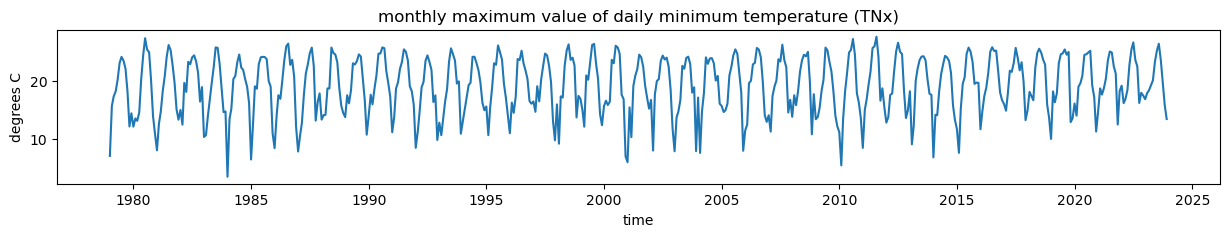

In [64]:
# plot
fig=plt.figure(figsize=(15,2))
TNx.plot()
plt.title('monthly maximum value of daily minimum temperature (TNx)')
plt.ylabel('degrees C')
plt.show()

### Annual Total Precip Amount Over 99th Percentile on Wet Days (R99pTOT)

- annually, the sum of precipitation when precipitation is > 99th percentile of wet day precipitation in the base period 1981-2010
- where a wet day is precipitation >= 1mm

Here we first use daily data during the base period to determine the 99th percentile of wet day precipitation. Then for each year of daily data we determine if each day exceeds the threshold and calculate an annual sum of precip on days that exceed the threshold. 

In [65]:
# slice pr to only base years
pr_baseyrs=pr.sel(time=slice('1981','2010'))
pr_baseyrs

<xarray.DataArray 'prcp' (time: 10950)> Size: 44kB
array([ 0.       ,  0.       ,  0.       , ...,  3.9274597,  7.7316895,
       17.509262 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 88kB 1981-01-01 1981-01-02 ... 2010-12-31
    lon      float64 8B -88.8
    lat      float64 8B 33.5
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

In [66]:
# find 99th percentile of wet day precipitation
pr_99w=xr.where(pr_baseyrs>=1.0,pr_baseyrs,np.nan).quantile(0.99)
pr_99w

<xarray.DataArray 'prcp' ()> Size: 8B
array(59.53603882)
Coordinates:
    quantile  float64 8B 0.99

In [67]:
# fill with nan where pr doesn't meet the criteria
pr_copy=pr.copy()
pr_copy=xr.where(pr_copy>pr_99w,pr_copy,np.nan)

# then sum over each year
R99pTOT=pr_copy.groupby(pr_copy.time.dt.year).sum()
R99pTOT

<xarray.DataArray 'prcp' (year: 45)> Size: 180B
array([205.38649 ,   0.      ,   0.      ,  94.68631 , 272.90924 ,
         0.      ,   0.      ,  65.066025,   0.      ,   0.      ,
         0.      , 226.00975 ,  62.0999  , 107.88191 , 181.73953 ,
        59.782852, 171.4772  ,  65.84659 ,   0.      ,  68.64018 ,
         0.      , 189.85739 ,  65.98627 , 230.10153 , 138.23347 ,
       177.36018 , 238.3673  ,  73.25783 , 135.16052 ,  62.798294,
       204.11293 ,   0.      , 167.39362 , 154.30484 ,  79.77347 ,
         0.      ,  82.977875,  63.636368,  63.71031 ,  62.51071 ,
       208.34439 , 132.57234 , 104.58713 ,  87.718765,  70.83397 ],
      dtype=float32)
Coordinates:
    lon       float64 8B -88.8
    lat       float64 8B 33.5
    quantile  float64 8B 0.99
  * year      (year) int64 360B 1979 1980 1981 1982 1983 ... 2020 2021 2022 2023

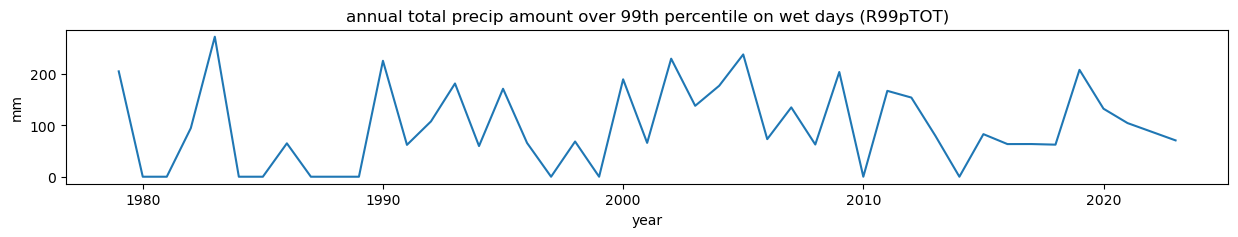

In [68]:
# plot
fig=plt.figure(figsize=(15,2))
R99pTOT.plot()
plt.title('annual total precip amount over 99th percentile on wet days (R99pTOT)')
plt.ylabel('mm')
plt.show()

### Monthly Maximum Consecutive 5-day Precipitation (Rx5day)

- max(5-day rolling mean precipitation within each month)

Here we are inputting daily data, for each month calculating the mean precipitation amount for each 5-day window of data values, then choosing the maximum of 5-day window value for each month.

In [69]:
# we want to group by each month so we'll use our month_groups again as a new coordinate of pr
pr.coords['month_groups']=('time',month_groups) 
pr

<xarray.DataArray 'prcp' (time: 16425)> Size: 66kB
array([31.362183  ,  0.        ,  0.        , ...,  0.21365356,
        0.        ,  0.        ], dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 131kB 1979-01-01 ... 2023-12-31
    lon           float64 8B -88.8
    lat           float64 8B 33.5
    month_groups  (time) object 131kB (1979, 1) (1979, 1) ... (2023, 12)
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

In [70]:
# find the maximum value of the 5-day rolling mean in each month
# let's test with one month first
window_len = 5  # days
label=(1979,5)

# use .rolling to divide the month of data up into 5-day windows
# then take the mean of each 5-day window if all 5 days in the window have finite data values (not nan)
# then find the maximum value of the above
# the result should be a single value
pr.groupby(pr.month_groups)[label].rolling(time=window_len,min_periods=window_len).mean().max()


<xarray.DataArray 'prcp' ()> Size: 4B
array(9.5278015, dtype=float32)
Coordinates:
    lon      float64 8B -88.8
    lat      float64 8B 33.5

In [71]:
# now do the calculation for all months using a for loop
results=[]  # empty list to hold the results

# loop through each label,group pair in the groupby object
for label,data_group in pr.groupby(pr.month_groups):
    # append the result for each month to our results list
    results.append(data_group.rolling(time=window_len,min_periods=window_len).mean().max())

# the result should be 1 value for every month (45 years x 12 months = length 540)
print(len(results))

# look at the fifth item in the list (1979-05)
results[4]

540


<xarray.DataArray 'prcp' ()> Size: 4B
array(9.5278015, dtype=float32)
Coordinates:
    lon      float64 8B -88.8
    lat      float64 8B 33.5

In [72]:
# even though each monthly calculation returns a single value
# that value is returned as an xarray DataArray with some metadata attached
# we have a list of xarray DataArray objects
# to get our results back into a single object we can concatenate the list of xr.DataArrays

Rx5day=xr.concat(results,dim='time') # concat on a new dimension called time
Rx5day

<xarray.DataArray 'prcp' (time: 540)> Size: 2kB
array([21.193508  , 12.252375  ,  8.633856  , 19.149258  ,  9.5278015 ,
        3.8091552 , 25.303371  ,  8.901709  , 15.566882  ,  4.9857483 ,
       16.408253  ,  8.175375  ,  9.225433  , 11.576981  , 19.671824  ,
       23.612427  , 17.308767  ,  7.1138062 ,  7.7941346 ,  1.4921204 ,
       15.08869   ,  8.955933  , 11.7183075 ,  4.047427  ,  5.066272  ,
        7.526273  , 11.695297  ,  4.711319  ,  8.124433  ,  6.7292876 ,
        6.9314055 ,  6.418695  ,  8.315054  ,  8.673291  ,  9.817017  ,
        5.0679197 , 15.187281  ,  9.228724  ,  5.488599  , 21.622406  ,
        4.1871095 ,  9.503159  , 12.84725   , 10.706037  ,  3.7023377 ,
       10.4168215 , 14.84548   , 20.412952  ,  7.4983397 , 13.046082  ,
       14.206241  , 27.74201   , 30.99079   ,  9.728284  ,  3.485431  ,
        3.470642  ,  5.130353  ,  9.148193  , 12.275378  , 17.530615  ,
        6.7785735 ,  7.9716096 , 12.747004  , 13.673816  , 13.663959  ,
        3.9800599 ,  4.418817  , 16.079596  ,  3.191278  , 13.41582   ,
        7.3783846 ,  5.163226  ,  8.374212  ,  7.9633913 ,  7.332367  ,
        5.3259153 , 10.546646  ,  5.3012633 , 14.294989  ,  7.948593  ,
       10.125949  , 18.270102  ,  4.3235106 ,  7.953537  ,  3.5988069 ,
        5.8583403 , 11.25654   ,  3.4919922 , 16.927526  , 10.809573  ,
        2.6424255 ,  6.749002  , 12.275381  , 15.3319    , 16.85523   ,
        8.055426  , 17.359715  , 21.27074   ,  9.692126  ,  4.279138  ,
...
       13.09374   , 14.411654  ,  8.462952  ,  7.432602  ,  6.5452394 ,
        6.965912  ,  4.522345  ,  2.8429017 ,  2.118219  , 15.907043  ,
       11.16123   , 24.478443  ,  7.3011446 ,  6.395694  , 11.031405  ,
       17.34657   , 16.393467  ,  3.3096008 , 17.719595  ,  5.3883576 ,
        6.7358522 ,  5.1648684 ,  8.972376  ,  6.6339693 , 16.888088  ,
        8.23617   , 13.343518  , 10.287005  ,  7.894376  ,  6.8837495 ,
        9.614893  , 16.066452  ,  7.06944   ,  9.848242  , 18.206013  ,
       16.465763  , 26.770828  ,  6.9429107 , 15.907049  , 14.676227  ,
       15.13635   , 10.07666   , 24.64606   ,  0.12653808, 20.066217  ,
        7.2732058 ,  9.481787  , 16.015503  , 21.926418  , 25.027304  ,
       21.239523  ,  7.3997407 ,  9.785803  ,  4.6998167 ,  4.76062   ,
       15.382843  ,  8.752176  ,  8.377493  , 10.503916  ,  6.91333   ,
        7.256778  , 15.877466  , 10.855578  , 13.041153  , 21.670063  ,
       10.968969  , 23.145733  ,  7.897662  ,  4.0835814 ,  3.661255  ,
        4.28407   , 15.994141  , 16.993265  , 10.844068  , 11.149729  ,
       12.755221  ,  4.640668  ,  7.8713684 , 23.388943  ,  8.104715  ,
        4.786905  ,  7.624869  , 10.464475  , 11.396219  , 10.679743  ,
        9.141632  , 17.343283  ,  5.9076414 , 30.879053  , 12.467642  ,
        2.5520446 ,  3.2915223 ,  0.913678  ,  7.8056335 ,  6.8689575 ],
      dtype=float32)
Coordinates:
    lon      float64 8B -88.8
    lat      float64 8B 33.5
Dimensions without coordinates: time

In [73]:
# make the new time dimension a coordinate (supply time labels)
# we'll use time_months again to assign the time coordinate labels
Rx5day.coords['time']=('time',time_months)    

# while we're at it, assign some variable attributes
# if we use xarray plotting, some of this will show up automagically on the plot
var_atts={'standard_name':'precipitation','units':'mm/day','description':'monthly maximum of monthly 5-day rolling mean prcp'}
Rx5day.attrs=var_atts

Rx5day

<xarray.DataArray 'prcp' (time: 540)> Size: 2kB
array([21.193508  , 12.252375  ,  8.633856  , 19.149258  ,  9.5278015 ,
        3.8091552 , 25.303371  ,  8.901709  , 15.566882  ,  4.9857483 ,
       16.408253  ,  8.175375  ,  9.225433  , 11.576981  , 19.671824  ,
       23.612427  , 17.308767  ,  7.1138062 ,  7.7941346 ,  1.4921204 ,
       15.08869   ,  8.955933  , 11.7183075 ,  4.047427  ,  5.066272  ,
        7.526273  , 11.695297  ,  4.711319  ,  8.124433  ,  6.7292876 ,
        6.9314055 ,  6.418695  ,  8.315054  ,  8.673291  ,  9.817017  ,
        5.0679197 , 15.187281  ,  9.228724  ,  5.488599  , 21.622406  ,
        4.1871095 ,  9.503159  , 12.84725   , 10.706037  ,  3.7023377 ,
       10.4168215 , 14.84548   , 20.412952  ,  7.4983397 , 13.046082  ,
       14.206241  , 27.74201   , 30.99079   ,  9.728284  ,  3.485431  ,
        3.470642  ,  5.130353  ,  9.148193  , 12.275378  , 17.530615  ,
        6.7785735 ,  7.9716096 , 12.747004  , 13.673816  , 13.663959  ,
        3.9800599 ,  4.418817  , 16.079596  ,  3.191278  , 13.41582   ,
        7.3783846 ,  5.163226  ,  8.374212  ,  7.9633913 ,  7.332367  ,
        5.3259153 , 10.546646  ,  5.3012633 , 14.294989  ,  7.948593  ,
       10.125949  , 18.270102  ,  4.3235106 ,  7.953537  ,  3.5988069 ,
        5.8583403 , 11.25654   ,  3.4919922 , 16.927526  , 10.809573  ,
        2.6424255 ,  6.749002  , 12.275381  , 15.3319    , 16.85523   ,
        8.055426  , 17.359715  , 21.27074   ,  9.692126  ,  4.279138  ,
...
       13.09374   , 14.411654  ,  8.462952  ,  7.432602  ,  6.5452394 ,
        6.965912  ,  4.522345  ,  2.8429017 ,  2.118219  , 15.907043  ,
       11.16123   , 24.478443  ,  7.3011446 ,  6.395694  , 11.031405  ,
       17.34657   , 16.393467  ,  3.3096008 , 17.719595  ,  5.3883576 ,
        6.7358522 ,  5.1648684 ,  8.972376  ,  6.6339693 , 16.888088  ,
        8.23617   , 13.343518  , 10.287005  ,  7.894376  ,  6.8837495 ,
        9.614893  , 16.066452  ,  7.06944   ,  9.848242  , 18.206013  ,
       16.465763  , 26.770828  ,  6.9429107 , 15.907049  , 14.676227  ,
       15.13635   , 10.07666   , 24.64606   ,  0.12653808, 20.066217  ,
        7.2732058 ,  9.481787  , 16.015503  , 21.926418  , 25.027304  ,
       21.239523  ,  7.3997407 ,  9.785803  ,  4.6998167 ,  4.76062   ,
       15.382843  ,  8.752176  ,  8.377493  , 10.503916  ,  6.91333   ,
        7.256778  , 15.877466  , 10.855578  , 13.041153  , 21.670063  ,
       10.968969  , 23.145733  ,  7.897662  ,  4.0835814 ,  3.661255  ,
        4.28407   , 15.994141  , 16.993265  , 10.844068  , 11.149729  ,
       12.755221  ,  4.640668  ,  7.8713684 , 23.388943  ,  8.104715  ,
        4.786905  ,  7.624869  , 10.464475  , 11.396219  , 10.679743  ,
        9.141632  , 17.343283  ,  5.9076414 , 30.879053  , 12.467642  ,
        2.5520446 ,  3.2915223 ,  0.913678  ,  7.8056335 ,  6.8689575 ],
      dtype=float32)
Coordinates:
    lon      float64 8B -88.8
    lat      float64 8B 33.5
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2023-12-01
Attributes:
    standard_name:  precipitation
    units:          mm/day
    description:    monthly maximum of monthly 5-day rolling mean prcp

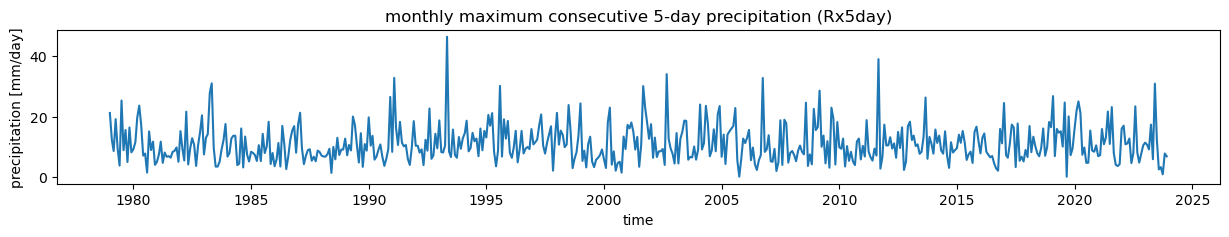

In [74]:
# plot
fig=plt.figure(figsize=(15,2))
Rx5day.plot() 
plt.title('monthly maximum consecutive 5-day precipitation (Rx5day)')
plt.show()

### Maximum Length of Consecutive Dry Days (CDD)

- annually, the maximum length of consecutive days where precipitation is < 1mm
- not looking at dry spells that span over multiple years, just cutting off the search at the end of each year

Here we are inputting daily data, determining whether each day falls under the precipitation threshold, and finding the longest period of consecutive days each year that meets the threshold requirement. 

In [75]:
# we'll use pr again 
pr

<xarray.DataArray 'prcp' (time: 16425)> Size: 66kB
array([31.362183  ,  0.        ,  0.        , ...,  0.21365356,
        0.        ,  0.        ], dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 131kB 1979-01-01 ... 2023-12-31
    lon           float64 8B -88.8
    lat           float64 8B 33.5
    month_groups  (time) object 131kB (1979, 1) (1979, 1) ... (2023, 12)
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

In [76]:
# make a mask where 1=dry and 0=wet
threshold = 1  # mm/day
dry_mask = xr.where(pr<threshold,1,0)
dry_mask

<xarray.DataArray 'prcp' (time: 16425)> Size: 66kB
array([0, 1, 1, ..., 1, 1, 1])
Coordinates:
  * time          (time) datetime64[ns] 131kB 1979-01-01 ... 2023-12-31
    lon           float64 8B -88.8
    lat           float64 8B 33.5
    month_groups  (time) object 131kB (1979, 1) (1979, 1) ... (2023, 12)

In [77]:
# group the data by year
dry_mask_grouped=dry_mask.groupby(dry_mask.time.dt.year)

# remind ourselves what this groupby object looks like
dry_mask_grouped

DataArrayGroupBy, grouped over 'year'
45 groups with labels 1979, 1980, 1981, ..., 2022, 2023.

In [78]:
# use nested for loops to find the longest stretch of dry days in each year

CDD=[] # empty list to store results

# loop through each year
for year,data_group in dry_mask_grouped:
    
    counter=0
    longest_counter=0

    # loop through each day
    for iday in range(len(data_group)):

        # if it's a dry day, increment the counter
        if data_group[iday]==1: counter+=1

        # keep track of the longest consecutive amount of dry days
        if counter>longest_counter: longest_counter=counter

        # if it's not a dry day (0 or nan), start the counter over at 0
        if data_group[iday]!=1: counter=0

    # add this year's result to the list
    CDD.append(longest_counter)

    # reset counters
    longest_counter=0
    counter=0

# look at the results for first 5 years
CDD[0:5]

[13, 18, 21, 14, 19]

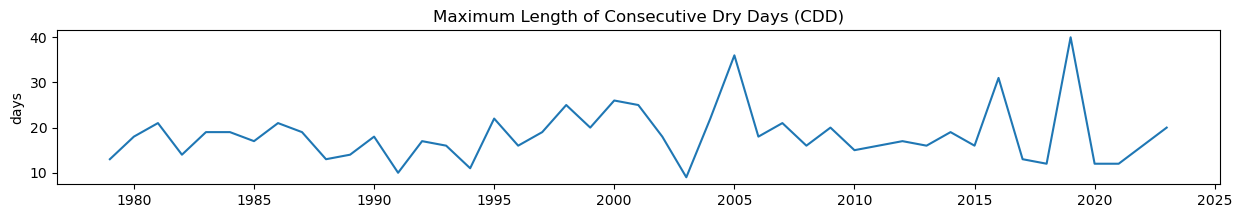

In [79]:
# annual datetimes for x axis values
time_annual=pd.date_range(tx.time.data[0],tx.time.data[-1],freq='YS')

# plot
fig=plt.figure(figsize=(15,2))
plt.plot(time_annual,CDD)
plt.title('Maximum Length of Consecutive Dry Days (CDD)')
plt.ylabel('days')
plt.show()

## Growing Season Length (GSL)

- annually, growing season starts on the first day of the first six consecutive day period where daily mean temperature is > 5C
- annually, growing season ends on the first day after 1 July of the first six consecutive day period where daily mean temperature is < 5C

Here we are inputting daily data, pulling out 2 dates per year, and calculating the number of days between the two dates.


In [80]:
threshold = 5   # degrees C
window_len = 6  # consectutive days

# calculate mean temperature
t_mean=(tn+tx)/2

to find the start and end of the growing season we will need to "roll" through time

we'll want to group by years to find the start and end of the growing season for each year

in this case we don't need to assign a new coordinate to use .groupby, we can use .dt.year on the time coordinate to select/subset/group. 

In [81]:
# groupby year
# let's look at what labels we get
t_mean.groupby(t_mean.time.dt.year)

DataArrayGroupBy, grouped over 'year'
45 groups with labels 1979, 1980, 1981, ..., 2022, 2023.

let's develop our code on 1 year first, then later we'll use a loop to calculate all years

In [82]:
# subset data to 1 year
year=1979
data_1yr=t_mean.groupby(t_mean.time.dt.year)[year]
data_1yr

<xarray.DataArray (time: 365)> Size: 1kB
array([ 8.1353035 , -4.288802  , -4.4386454 , -0.8546457 ,  1.1774075 ,
        6.779866  ,  6.0748196 , -4.3675547 , -3.2942595 ,  0.11734867,
        0.77373075,  2.594514  ,  6.378198  , -3.3522277 , -1.9103057 ,
        2.890925  , 11.7818575 ,  9.920426  , 10.064592  , 11.158965  ,
       -0.4764247 , -1.6299584 ,  3.8228197 , -1.0631053 , -0.27095938,
       -0.23414445,  1.7851415 , -0.5003214 ,  0.1952014 ,  1.0431843 ,
       -1.8708985 , -1.0794535 ,  0.29778528,  4.0356693 ,  3.810256  ,
        1.7415557 ,  1.8159289 ,  3.236442  ,  3.9993129 , -2.4971035 ,
        0.21872807,  3.8254037 ,  7.8650293 ,  6.0996947 , 12.939138  ,
       16.741783  ,  7.9939957 ,  1.379816  ,  2.45297   ,  2.96456   ,
        5.355425  , 12.35103   , 16.464214  , 19.008556  , 17.166714  ,
        8.452247  ,  4.397326  ,  5.002684  ,  9.701976  , 11.323724  ,
       12.077646  , 16.609367  , 10.789961  ,  6.4605026 ,  8.075328  ,
       11.900557  ,  6.7615557 , 10.216373  ,  7.119954  ,  5.3154063 ,
       11.493533  , 12.259903  , 10.415325  ,  8.059163  ,  8.8126    ,
       14.2029915 , 16.698421  , 18.189552  , 17.78302   , 16.939842  ,
       17.775875  , 14.240146  ,  8.453808  ,  5.6677475 ,  7.598219  ,
       13.066741  , 16.420547  , 18.289589  , 18.387362  , 20.609434  ,
       21.617504  , 17.296993  , 15.194509  , 13.205258  , 11.844173  ,
       13.822305  , 15.880647  , 16.064568  , 13.496645  , 14.056612  ,
...
       20.966152  , 21.579288  , 22.338875  , 22.125307  , 17.978846  ,
       17.8994    , 15.852444  , 14.210393  , 17.352623  , 18.207617  ,
       21.671387  , 19.042458  , 11.6243725 , 14.649393  , 20.769947  ,
       14.808371  , 12.341598  , 14.419032  , 17.187122  , 18.906313  ,
       20.161898  , 21.415573  , 22.681904  , 23.35585   , 19.977499  ,
       12.528366  , 11.439746  , 11.905024  , 14.058121  , 16.675364  ,
       18.798317  , 18.587778  , 18.763556  , 19.393993  , 12.671651  ,
       11.690875  , 10.257289  ,  8.947262  , 10.468411  , 12.3520975 ,
        9.490822  , 11.935866  , 15.969742  , 11.480764  ,  8.64254   ,
        7.9788494 ,  7.248757  ,  5.994166  ,  7.061735  , 11.989148  ,
       11.849103  , 12.418754  , 14.961432  , 15.350905  , 16.49037   ,
       14.875176  ,  6.382844  ,  6.6305065 , 11.825587  , 10.300137  ,
       14.130825  ,  9.964463  ,  0.9073391 ,  0.33711958,  3.3090315 ,
        0.8996    ,  1.4090123 ,  4.22398   ,  7.8843946 ,  7.0836306 ,
        6.9091    ,  6.053909  ,  5.5644155 ,  9.734103  , 13.3338375 ,
       17.267231  , 11.69383   ,  5.816677  ,  5.877605  ,  6.921958  ,
       -1.572335  ,  0.1842575 ,  4.4846277 ,  8.791329  , 11.964463  ,
       10.386658  , 14.793819  , 12.270062  ,  6.4803944 ,  5.6211376 ,
        6.084346  ,  6.5973954 ,  8.828471  ,  6.243507  ,  5.918876  ],
      dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 3kB 1979-01-01 1979-01-02 ... 1979-12-31
    lon           float64 8B -88.8
    lat           float64 8B 33.5
    doy           (time) int32 1kB 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365
    month_groups  (time) object 3kB (1979, 1) (1979, 1) ... (1979, 12)

In [83]:
# make a mask for where daily temperature is greater than 5C
warm_mask=xr.where(data_1yr>threshold,1,0)
warm_mask

<xarray.DataArray (time: 365)> Size: 1kB
array([1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Coordinates:
  * time          (time) datetime64[ns] 3kB 1979-01-01 1979-01-02 ... 1979-12-31
    lon           float64 8B -88.8
    lat           float64 8B 33.5
    doy           (time) int32 1kB 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365
    month_groups  (time) object 3kB (1979, 1) (1979, 1) ... (1979, 12)

Now we want to partition the timeseries into rolling windows of length 6

The first window will have the first value of the data_mask (index 0) in the last position of the window plus the 5 preceeding values of the data_mask, which in this case are nan because we're at the beginning of the data_mask array

The 6th window (index 5) should be equal to the first 6 values of data_mask (no nans)

In [84]:
# create the windows
windows=warm_mask.rolling(time=window_len,center=False).construct('window')

# print the window with the first 6 values of data_mask
print(windows.isel(time=window_len-1))

# print array info
windows

<xarray.DataArray (window: 6)> Size: 48B
array([1., 0., 0., 0., 0., 1.])
Coordinates:
    time          datetime64[ns] 8B 1979-01-06
    lon           float64 8B -88.8
    lat           float64 8B 33.5
    doy           int32 4B 6
    month_groups  object 8B (1979, 1)
Dimensions without coordinates: window


<xarray.DataArray (time: 365, window: 6)> Size: 18kB
array([[nan, nan, nan, nan, nan,  1.],
       [nan, nan, nan, nan,  1.,  0.],
       [nan, nan, nan,  1.,  0.,  0.],
       ...,
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.]])
Coordinates:
  * time          (time) datetime64[ns] 3kB 1979-01-01 1979-01-02 ... 1979-12-31
    lon           float64 8B -88.8
    lat           float64 8B 33.5
    doy           (time) int32 1kB 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365
    month_groups  (time) object 3kB (1979, 1) (1979, 1) ... (1979, 12)
Dimensions without coordinates: window

In [85]:
# find the sum of each window
# this will tell us how many days per window are over the 5C threshold
# ignore windows that contain any nans
windows.sum('window',min_count=window_len)

<xarray.DataArray (time: 365)> Size: 3kB
array([nan, nan, nan, nan, nan,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,
        1.,  1.,  1.,  2.,  3.,  3.,  4.,  4.,  4.,  3.,  2.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  2.,  3.,  4.,  5.,  5.,  4.,  3.,  3.,  3.,
        3.,  4.,  5.,  6.,  5.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  5.,  4.,  3.,  2.,  1.,  0.,
        1.,  2.,  3.,  4.,  5.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  5.,
        4.,  3.,  3.,  3.,  3.,  4.,  5.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.])
Coordinates:
  * time          (time) datetime64[ns] 3kB 1979-01-01 1979-01-02 ... 1979-12-31
    lon           float64 8B -88.8
    lat           float64 8B 33.5
    doy           (time) int32 1kB 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365
    month_groups  (time) object 3kB (1979, 1) (1979, 1) ... (1979, 12)

Find the indexes of each 6-day window where all days were over the 5C threshold with np.where

np.where returns a tuple in this case where the resulting array is in the first index of the tuple. This is why we use the [0] to pull the array from the tuple

In [86]:
# indexes of every window where all days are over the threshold
np.where(windows.sum('window')==window_len)[0]

array([ 55,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
       204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
       217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
       230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 24

But we need to adjust these indexes. Why?

Take the first value of the result above (55). This is the first window where the requirement was met (all 6 days above 5C). The windows are indexed as their last day, i.e. the 5th index window contains index days 0,1,2,3,4,5.

The start of the growing season is the first day of the first 6-day period meeting the 5C requirement, so to get the index of the first day in the window we subtract 5 (window_len-1).


In [87]:
# find index of start of growing season
# windows are indexed to their last day, switch to first day index
gs_start_ind=np.where(windows.sum('window')==window_len)[0][0] - (window_len-1)
gs_start_ind

50

In [88]:
# now let's search for the end of the growing season
# we know to only look after July 1, what index is that?
label=str(year)+'-07-01'
minval=t_mean.indexes['time'].get_loc(label)
minval

181

In [89]:
# now do similar steps to find the end of the growing season

# 0/1 mask for where temperature is less than 5C
warm_mask=xr.where(data_1yr<threshold,1,0)
warm_mask

<xarray.DataArray (time: 365)> Size: 1kB
array([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Coordinates:
  * time          (time) datetime64[ns] 3kB 1979-01-01 1979-01-02 ... 1979-12-31
    lon           float64 8B -88.8
    lat           float64 8B 33.5
    doy           (time) int32 1kB 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365
    month_groups  (time) object 3kB (1979, 1) (1979, 1) ... (1979, 12)

In [90]:
# split up into 6-day windows
windows=warm_mask.rolling(time=window_len,center=False).construct('window')
windows

<xarray.DataArray (time: 365, window: 6)> Size: 18kB
array([[nan, nan, nan, nan, nan,  0.],
       [nan, nan, nan, nan,  0.,  1.],
       [nan, nan, nan,  0.,  1.,  1.],
       ...,
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])
Coordinates:
  * time          (time) datetime64[ns] 3kB 1979-01-01 1979-01-02 ... 1979-12-31
    lon           float64 8B -88.8
    lat           float64 8B 33.5
    doy           (time) int32 1kB 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365
    month_groups  (time) object 3kB (1979, 1) (1979, 1) ... (1979, 12)
Dimensions without coordinates: window

In [91]:
# get the index to all the windows where temperature is always less than 5C
np.where(windows.sum('window')==window_len)[0]

array([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41, 337], dtype=int64)

In [92]:
# windows are indexed to their last day, switch to first day index
possible_inds=np.where(windows.sum('window')==window_len)[0] - (window_len-1)
possible_inds

array([ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36, 332], dtype=int64)

In [93]:
# subset possible_inds to only indexes that correspond to days after July 1
# and take the first value in that result
gs_end_ind=possible_inds[possible_inds>minval][0]
gs_end_ind

332

In [94]:
# functions to do what we did above for each year
# we'll put these functions in a loop below

def get_gs_start(data_1yr):
    mask=xr.where(data_1yr>threshold,1,0)
    windows=mask.rolling(time=window_len,center=False).construct('window')
    ind=np.where(windows.sum('window')==window_len)[0][0] - (window_len-1)
    return ind

def get_gs_end(data_1yr):
    mask=xr.where(data_1yr<threshold,1,0)
    windows=mask.rolling(time=window_len,center=False).construct('window')
    # sometimes it may be warm through the end of the year
    # in these cases we would end up with an error if no windows meet the <5C requirement
    # try/except works to pass in the last day of the year as the end of the growing season in these cases
    try:
        possible_inds=np.where(windows.sum('window')==window_len)[0]
        ind=possible_inds[possible_inds>minval][0]
    except:
        ind=364 # index of the last day of year
    return ind

In [95]:
# group the data by year and loop through each year's worth of data
# to find the index of the start and end of the growing season 

# create empty lists for storing results
gs_start_list=[]
gs_end_list=[]

# loop through years of data
# .groupby returns an object that can be iterated over in the form (label,group_array_of_data) pairs
# here "label" are the years
# and "group" are a year's worth of data values
for label,group in t_mean.groupby(t_mean.time.dt.year):
    # call our functions and append the result to our lists
    gs_start_list.append(get_gs_start(group))
    gs_end_list.append(get_gs_end(group))

# look at the first 5 values of each list
gs_start_list[0:5], gs_end_list[0:5]

([50, 12, 22, 0, 5], [337, 364, 364, 364, 360])

In [96]:
# double check our work
assert all(x>=0 for x in gs_start_list), "negative values in gs_start_list"
assert all(x<=364 for x in gs_start_list), "values>364 in gs_start_list"
assert all(x>=minval for x in gs_end_list), f"values<{minval} in gs_end_list"
assert all(x<=364 for x in gs_start_list), "values>364 in gs_end_list"

In [97]:
# calculate the growing season length for each year
# this is called a "list comprehension"
# it executes a for loop and returns results inside a list
GSL = [end_ind-start_ind for end_ind,start_ind in zip(gs_end_list,gs_start_list)] 

# # below is identical to above
# GSL=[]
# for end_ind,start_ind in zip(gs_end_list,gs_start_list):
#     GSL.append(end_ind-start_ind)

# check out the first 5 values
GSL[0:5]

[287, 352, 342, 364, 355]

Text(0.5, 1.0, 'End of Growing Season DOY')

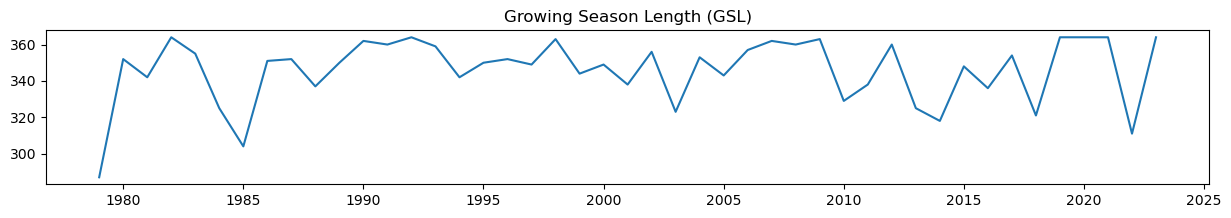

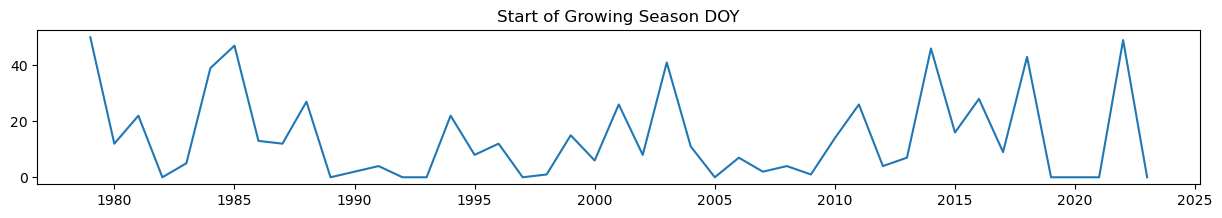

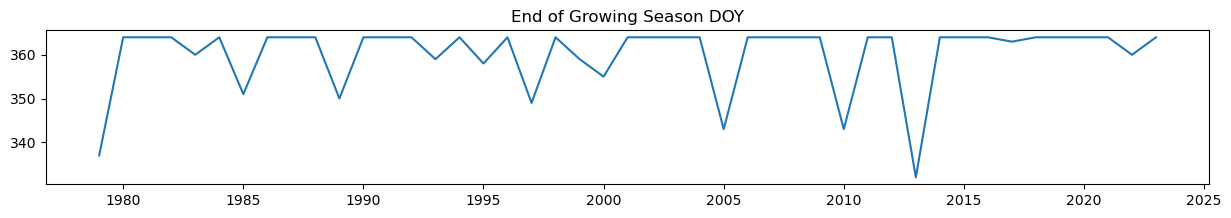

In [98]:
# using annual datetimes that we've already created for x axis values

# plot
fig=plt.figure(figsize=(15,2))
plt.plot(time_annual,GSL)
plt.title('Growing Season Length (GSL)')

fig=plt.figure(figsize=(15,2))
plt.plot(time_annual,gs_start_list)
plt.title('Start of Growing Season DOY')

fig=plt.figure(figsize=(15,2))
plt.plot(time_annual,gs_end_list)
plt.title('End of Growing Season DOY')

# Trends Analysis

Here, we will calculate the **[least squares linear regression](https://towardsdatascience.com/linear-regression-using-least-squares-a4c3456e8570)** (aka linear trend) on our climate change indicators (TNx, R99pTOT, Rx5day, CDD, and GSL) and determine if the trends are statistically significant using **[scipy.stats.linregress](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html)**.

A statistically significant trend means the slope of the linear regression line is statistically different than zero. **[scipy.stats.linregress](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html)** calculates statistical significance and provides a p value based on a two-tailed t-test. This scipy function also calculates r (correlation) from which we can get r<sup>2</sup> (coefficient of determination), a measure of the goodness of fit (or variance explained) of the linear regression. Here are two links with refreshers on linear trend **[p values](https://online.stat.psu.edu/stat501/lesson/2/2.12)** and **[r<sup>2</sup>](https://www.ncl.ac.uk/webtemplate/ask-assets/external/maths-resources/statistics/regression-and-correlation/coefficient-of-determination-r-squared.html#:~:text=6%20See%20Also-,Definition,line%20approximates%20the%20actual%20data.)**

**Big caveats:** 

1) We are calculating trends and statistical significance on only 45 years of data. In climate science, this would not be considered enough data years to robustly estimate long term change. For long term trend analysis, I personally try to use at least 80 data years, preferably 100, in order to minimize the impact of multi-decadal climate variability (**[read more about climate variability](https://climate.metoffice.cloud/climate_modes.html)**). Using even more than 100 data years would be ideal, but then you have to more carefully consider the impact of data quality and quantity. What we are calculating is the trend over a recent 45 year data period and our results would almost certainly change if we used more data years. All to say, it would be wise not to interpret our 45-year trends as the rate of change that will continue into the future. 
2) The p values provided by **[scipy.stats.linregress](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html)** or linear regression functions from other packages do not account for serial autocorrelation. For a scientific publication, you would likely need to calculate statistical significance more robustly by choosing a test statistic and calculating p values yourself that account for autocorrelation, which is beyond the scope of this workshop. And actually, most functions for linear regression (e.g. from **[xarray.DataArray.polyfit](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.polyfit.html)**, **[numpy.polynomial.polynomial.polyfit](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.polyfit.html)**, **[sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)**) won't provide you with extra statistics like p, r, r<sup>2</sup>, so you'll have to calculate them yourself anyways if you use those functions.   


### Annual Total Precip Amount Over 99th Percentile on Wet Days (R99pTOT)

We'll start with R99pTOT because it's already in an xarray data array structure, so it will be slightly easier to work with than our climate change indicators that are stored in python lists.

In [99]:
# remind ourselves what our data array looks like
R99pTOT

<xarray.DataArray 'prcp' (year: 45)> Size: 180B
array([205.38649 ,   0.      ,   0.      ,  94.68631 , 272.90924 ,
         0.      ,   0.      ,  65.066025,   0.      ,   0.      ,
         0.      , 226.00975 ,  62.0999  , 107.88191 , 181.73953 ,
        59.782852, 171.4772  ,  65.84659 ,   0.      ,  68.64018 ,
         0.      , 189.85739 ,  65.98627 , 230.10153 , 138.23347 ,
       177.36018 , 238.3673  ,  73.25783 , 135.16052 ,  62.798294,
       204.11293 ,   0.      , 167.39362 , 154.30484 ,  79.77347 ,
         0.      ,  82.977875,  63.636368,  63.71031 ,  62.51071 ,
       208.34439 , 132.57234 , 104.58713 ,  87.718765,  70.83397 ],
      dtype=float32)
Coordinates:
    lon       float64 8B -88.8
    lat       float64 8B 33.5
    quantile  float64 8B 0.99
  * year      (year) int64 360B 1979 1980 1981 1982 1983 ... 2020 2021 2022 2023

In [100]:
# scipy.stats.linregress
# x values are the years (do not use datetimes for x, you will get incorrect results without an error thrown)
# y values are the climate change index values in xarray data array format

reg_info=ss.linregress(R99pTOT.year,R99pTOT)

# see what info is returned
reg_info

LinregressResult(slope=0.7404163606867331, intercept=-1384.3481240012427, rvalue=0.1223809671218204, pvalue=0.4232059355009309, stderr=0.9156954606227679, intercept_stderr=1832.3452088287356)

The slope of the linear regression is the 'trend'. The units of the trend will be y units/x units, which in this case is mm/year. Here we have a positive (increasing) trend of 0.609 mm/year.

Personally, I like to present my trends as units/century, which here means muliplying by 100 years/century.

In [101]:
# save trend as a new variable and change units
trend=reg_info.slope*100 # mm/year --> mm/century
trend

74.04163606867331

In [102]:
# if we want to plot the linear trend we will need to create the data points
# y = mx + b
regline=reg_info.slope*R99pTOT.year +reg_info.intercept
regline

<xarray.DataArray 'year' (year: 45)> Size: 360B
array([ 80.9358538 ,  81.67627016,  82.41668652,  83.15710288,
        83.89751924,  84.6379356 ,  85.37835196,  86.11876832,
        86.85918468,  87.59960104,  88.3400174 ,  89.08043377,
        89.82085013,  90.56126649,  91.30168285,  92.04209921,
        92.78251557,  93.52293193,  94.26334829,  95.00376465,
        95.74418101,  96.48459737,  97.22501373,  97.96543009,
        98.70584645,  99.44626281, 100.18667918, 100.92709554,
       101.6675119 , 102.40792826, 103.14834462, 103.88876098,
       104.62917734, 105.3695937 , 106.11001006, 106.85042642,
       107.59084278, 108.33125914, 109.0716755 , 109.81209186,
       110.55250823, 111.29292459, 112.03334095, 112.77375731,
       113.51417367])
Coordinates:
    lon       float64 8B -88.8
    lat       float64 8B 33.5
    quantile  float64 8B 0.99
  * year      (year) int64 360B 1979 1980 1981 1982 1983 ... 2020 2021 2022 2023

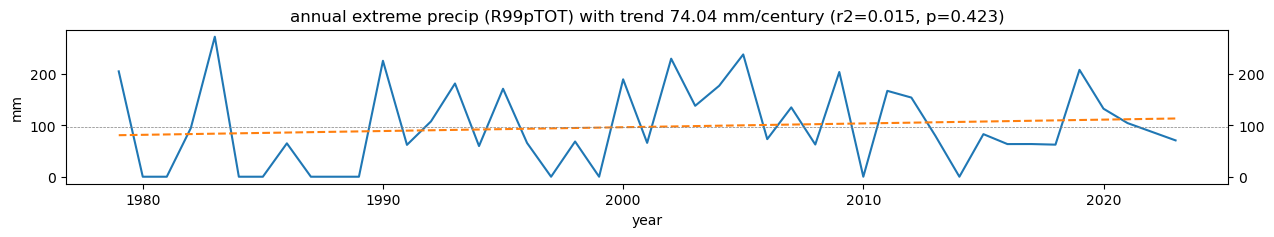

In [103]:
# plot the linear regression over the timeseries TNx

fig=plt.figure(figsize=(15,2))

R99pTOT.plot()  # the climate change indicator timeseries
regline.plot(linestyle='--')  # the linear regression line

plt.axhline(y=R99pTOT.mean(),color='grey',linestyle='dashed',linewidth=0.5) # a guide line at the data mean
plt.tick_params(labelright=True, right=True) # add ticks and tick labels to right-side axis 
plt.ylabel('mm')  # y axis label
plt.title(f'annual extreme precip (R99pTOT) with trend {trend:.2f} mm/century (r2={reg_info.rvalue**2:.3f}, p={reg_info.pvalue:.3f})') # informative title

plt.show() # show everything together

The figure above shows that the increasing trend of 60.93 mm/century in R99pTOT is meaningless because the trend is not statistically significant.

Let's check our result against a map provided by **[climdex.org](https://www.climdex.org/access/)**. What is different about the information provided on this map vs our analysis? Is R99pTOT near Starkville similar? What area of CONUS have significant R99pTOT trends?

<img src="figs/REGEN-LONG V1 2019 masked_R99pTOT_ANN_TrendMap_1972-2016_24to51_-125to-65.png"/>

### Maximum Length of Consecutive Dry Days (CDD)

In [104]:
# remind ourselves what CDD looks like
CDD

[13,
 18,
 21,
 14,
 19,
 19,
 17,
 21,
 19,
 13,
 14,
 18,
 10,
 17,
 16,
 11,
 22,
 16,
 19,
 25,
 20,
 26,
 25,
 18,
 9,
 22,
 36,
 18,
 21,
 16,
 20,
 15,
 16,
 17,
 16,
 19,
 16,
 31,
 13,
 12,
 40,
 12,
 12,
 16,
 20]

In [105]:
# linear regression
# x = years, y = climate change indicator values in list format
reg_info=ss.linregress(time_annual.year,CDD) 

# convert trend units
trend=reg_info.slope*100 # days/year --> days/century

# create regression line for plotting, y = mx + b
regline=reg_info.slope*time_annual.year +reg_info.intercept

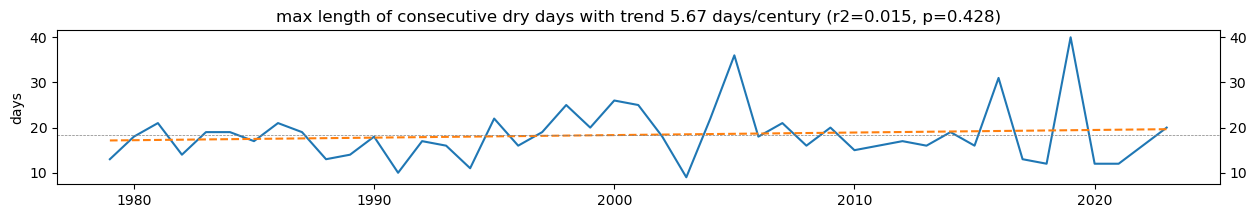

In [106]:
# plot the linear regression over the data
fig=plt.figure(figsize=(15,2))
plt.plot(time_annual.year,CDD) 
plt.plot(time_annual.year,regline,linestyle='--')
plt.axhline(y=np.asarray(CDD).mean(),color='grey',linestyle='dashed',linewidth=0.5)
plt.tick_params(labelright=True, right=True)
plt.ylabel('days')
plt.title(f'max length of consecutive dry days with trend {trend:.2f} days/century (r2={reg_info.rvalue**2:.3f}, p={reg_info.pvalue:.3f})')
plt.show()

The figure above shows that the increasing trend of 5.67 days/century in CDD is meaningless because the trend is not statistically significant.

Let's check our result against a map provided by **[climdex.org](https://www.climdex.org/access/)**. What is different about the information provided on this map vs our analysis? Is CDD near Starkville similar? What areas of CONUS have significant CDD trends?

<img src="figs/REGEN-LONG V1 2019 masked_CDD_ANN_TrendMap_1972-2016_24to51_-125to-65.png"/>

### Growing Season Length (GSL)

In [107]:
# remind ourselves what GSL looks like
GSL

[287,
 352,
 342,
 364,
 355,
 325,
 304,
 351,
 352,
 337,
 350,
 362,
 360,
 364,
 359,
 342,
 350,
 352,
 349,
 363,
 344,
 349,
 338,
 356,
 323,
 353,
 343,
 357,
 362,
 360,
 363,
 329,
 338,
 360,
 325,
 318,
 348,
 336,
 354,
 321,
 364,
 364,
 364,
 311,
 364]

In [108]:
# linear regression
# x = years, y = climate change indicator values in list format
reg_info=ss.linregress(time_annual.year,GSL)

# convert trend units
trend=reg_info.slope*100 # days/year --> days/century

# create regression line for plotting, y = mx + b
regline=reg_info.slope*time_annual.year +reg_info.intercept

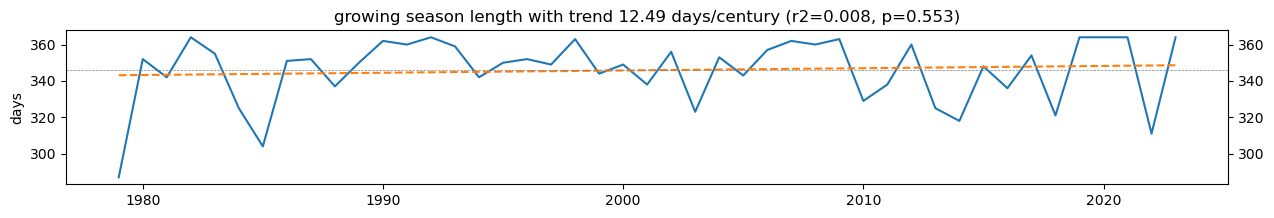

In [109]:
# plot the linear regression over the data
fig=plt.figure(figsize=(15,2))
plt.plot(time_annual.year,GSL) 
plt.plot(time_annual.year,regline,linestyle='--')
plt.axhline(y=np.asarray(GSL).mean(),color='grey',linestyle='dashed',linewidth=0.5)
plt.tick_params(labelright=True, right=True)
plt.ylabel('days')
plt.title(f'growing season length with trend {trend:.2f} days/century (r2={reg_info.rvalue**2:.3f}, p={reg_info.pvalue:.3f})')
plt.show()

The figure above shows that the increasing trend of 12.49 days/century in GSL is meaningless because the trend is not statistically significant.

Let's check our result against a map provided by **[climdex.org](https://www.climdex.org/access/)**. What is different about the information provided on this map vs our analysis? Is GSL near Starkville similar? What areas of CONUS have significant GSL trends?

<img src="figs/BEST (Berkeley Earth Surface Temperature) 1880-2021_GSL_ANN_TrendMap_1977-2021_24to51_-125to-65.png"/>

### TNx

In [110]:
# remind ourselves what TNx looks like
TNx

<xarray.DataArray 'tmin' (time: 540)> Size: 2kB
array([ 7.149189 , 15.696419 , 17.327755 , 18.195263 , 20.149757 ,
       23.05989  , 24.1054   , 23.452171 , 22.083511 , 18.259205 ,
       12.190084 , 14.446995 , 12.164164 , 13.572573 , 13.161282 ,
       14.604254 , 20.232704 , 24.352516 , 27.293758 , 25.34618  ,
       24.90033  , 20.199871 , 13.954485 , 10.982136 ,  8.104834 ,
       12.684324 , 14.711395 , 18.267845 , 20.7304   , 24.096756 ,
       26.13247  , 25.27533  , 22.65897  , 19.714272 , 15.136509 ,
       13.360014 , 15.022455 , 12.502872 , 19.646877 , 18.115772 ,
       23.262081 , 22.84388  , 24.01381  , 24.364616 , 23.324291 ,
       21.404362 , 16.458515 , 18.92971  , 10.398035 , 10.710823 ,
       13.835245 , 16.767845 , 19.612312 , 22.363464 , 25.72118  ,
       25.648602 , 22.881897 , 18.874413 , 14.643999 , 14.766695 ,
        3.592741 , 13.413586 , 15.257477 , 20.307014 , 20.821991 ,
       23.184315 , 24.504593 , 22.289154 , 21.8554   , 20.291462 ,
       18.981556 , 16.201027 ,  6.5408955, 12.784554 , 19.069687 ,
       18.65667  , 22.883625 , 24.032818 , 24.11404  , 24.077747 ,
       23.70102  , 20.006325 , 19.002293 , 11.04262  ,  8.48329  ,
       13.990774 , 17.542038 , 16.93029  , 20.084087 , 23.542034 ,
       25.904362 , 26.374405 , 22.73328  , 23.60252  , 20.661278 ,
       12.101952 ,  7.9078293, 10.672804 , 12.827757 , 17.663006 ,
...
       14.917042 , 17.396877 , 18.872684 , 21.33524  , 24.978092 ,
       25.755741 , 25.109428 , 25.169914 , 21.808743 , 18.0069   ,
       16.702179 , 16.048954 , 14.887663 , 17.815079 , 21.732704 ,
       21.539154 , 23.07026  , 25.63823  , 23.979248 , 21.796642 ,
       23.177402 , 19.800678 , 13.287434 , 14.951603 , 18.114044 ,
       17.448723 , 16.672798 , 22.216576 , 24.762081 , 25.496525 ,
       24.831203 , 23.59042  , 22.77821  , 15.98674  , 13.7211895,
       10.061054 , 18.190079 , 16.328907 , 17.84446  , 22.985584 ,
       24.547794 , 24.699867 , 25.375557 , 24.473484 , 24.94526  ,
       12.9349   , 13.576029 , 16.121532 , 14.046074 , 18.98674  ,
       19.608856 , 20.872105 , 24.444107 , 24.552979 , 24.8433   ,
       25.149178 , 19.209663 , 17.224068 , 11.319117 , 14.811626 ,
       18.713696 , 17.652637 , 18.768997 , 20.38132  , 23.479824 ,
       25.031666 , 24.846756 , 22.474064 , 21.26957  , 12.525337 ,
       18.260933 , 19.175102 , 16.187202 , 16.902637 , 18.442383 ,
       22.665882 , 25.33754  , 26.583508 , 23.585236 , 22.46024  ,
       16.214851 , 17.953327 , 17.493652 , 16.857708 , 17.920494 ,
       18.378445 , 19.258053 , 20.068535 , 23.224064 , 25.114613 ,
       26.353668 , 23.52821  , 19.65379  , 15.79665  , 13.465429 ],
      dtype=float32)
Coordinates:
    lon      float64 8B -88.8
    lat      float64 8B 33.5
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2023-12-01
Attributes:
    long_name:             Minimum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Min 00-00LT
    units:                 degrees_C
    standard_name:         2m_min_air_temperature

In [111]:
# you can't supply datetimes as the xvalues to a linear regression function
# if you use datetimes, you probably won't get an error but you'll get incorrect results
# instead of datetimes, supply integers or floats
# here we'll make a new coordinate of integer values from 0 to 539
TNx.coords['index']=('time',range(len(TNx.time)))
TNx

<xarray.DataArray 'tmin' (time: 540)> Size: 2kB
array([ 7.149189 , 15.696419 , 17.327755 , 18.195263 , 20.149757 ,
       23.05989  , 24.1054   , 23.452171 , 22.083511 , 18.259205 ,
       12.190084 , 14.446995 , 12.164164 , 13.572573 , 13.161282 ,
       14.604254 , 20.232704 , 24.352516 , 27.293758 , 25.34618  ,
       24.90033  , 20.199871 , 13.954485 , 10.982136 ,  8.104834 ,
       12.684324 , 14.711395 , 18.267845 , 20.7304   , 24.096756 ,
       26.13247  , 25.27533  , 22.65897  , 19.714272 , 15.136509 ,
       13.360014 , 15.022455 , 12.502872 , 19.646877 , 18.115772 ,
       23.262081 , 22.84388  , 24.01381  , 24.364616 , 23.324291 ,
       21.404362 , 16.458515 , 18.92971  , 10.398035 , 10.710823 ,
       13.835245 , 16.767845 , 19.612312 , 22.363464 , 25.72118  ,
       25.648602 , 22.881897 , 18.874413 , 14.643999 , 14.766695 ,
        3.592741 , 13.413586 , 15.257477 , 20.307014 , 20.821991 ,
       23.184315 , 24.504593 , 22.289154 , 21.8554   , 20.291462 ,
       18.981556 , 16.201027 ,  6.5408955, 12.784554 , 19.069687 ,
       18.65667  , 22.883625 , 24.032818 , 24.11404  , 24.077747 ,
       23.70102  , 20.006325 , 19.002293 , 11.04262  ,  8.48329  ,
       13.990774 , 17.542038 , 16.93029  , 20.084087 , 23.542034 ,
       25.904362 , 26.374405 , 22.73328  , 23.60252  , 20.661278 ,
       12.101952 ,  7.9078293, 10.672804 , 12.827757 , 17.663006 ,
...
       14.917042 , 17.396877 , 18.872684 , 21.33524  , 24.978092 ,
       25.755741 , 25.109428 , 25.169914 , 21.808743 , 18.0069   ,
       16.702179 , 16.048954 , 14.887663 , 17.815079 , 21.732704 ,
       21.539154 , 23.07026  , 25.63823  , 23.979248 , 21.796642 ,
       23.177402 , 19.800678 , 13.287434 , 14.951603 , 18.114044 ,
       17.448723 , 16.672798 , 22.216576 , 24.762081 , 25.496525 ,
       24.831203 , 23.59042  , 22.77821  , 15.98674  , 13.7211895,
       10.061054 , 18.190079 , 16.328907 , 17.84446  , 22.985584 ,
       24.547794 , 24.699867 , 25.375557 , 24.473484 , 24.94526  ,
       12.9349   , 13.576029 , 16.121532 , 14.046074 , 18.98674  ,
       19.608856 , 20.872105 , 24.444107 , 24.552979 , 24.8433   ,
       25.149178 , 19.209663 , 17.224068 , 11.319117 , 14.811626 ,
       18.713696 , 17.652637 , 18.768997 , 20.38132  , 23.479824 ,
       25.031666 , 24.846756 , 22.474064 , 21.26957  , 12.525337 ,
       18.260933 , 19.175102 , 16.187202 , 16.902637 , 18.442383 ,
       22.665882 , 25.33754  , 26.583508 , 23.585236 , 22.46024  ,
       16.214851 , 17.953327 , 17.493652 , 16.857708 , 17.920494 ,
       18.378445 , 19.258053 , 20.068535 , 23.224064 , 25.114613 ,
       26.353668 , 23.52821  , 19.65379  , 15.79665  , 13.465429 ],
      dtype=float32)
Coordinates:
    lon      float64 8B -88.8
    lat      float64 8B 33.5
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2023-12-01
    index    (time) int32 2kB 0 1 2 3 4 5 6 7 ... 533 534 535 536 537 538 539
Attributes:
    long_name:             Minimum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Min 00-00LT
    units:                 degrees_C
    standard_name:         2m_min_air_temperature

In [112]:
# linear regression
# x = integers 0 to 539, y = climate change indicator values in xarray DataArray
reg_info=ss.linregress(TNx.index,TNx)

# convert trend units
trend=reg_info.slope*12*100 # C/month --> C/century

# create regression line for plotting, y = mx + b
regline=reg_info.slope*TNx.index +reg_info.intercept

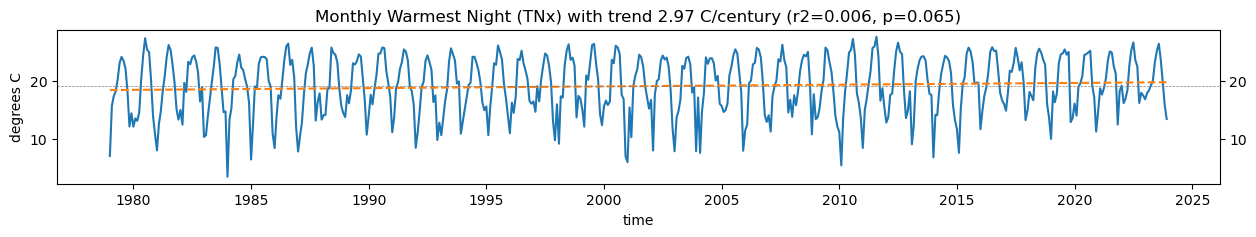

In [113]:
# plot the linear regression over the timeseries TNx
fig=plt.figure(figsize=(15,2))
TNx.plot()
regline.plot(linestyle='--')
plt.axhline(y=TNx.mean(),color='grey',linestyle='dashed',linewidth=0.5)
plt.tick_params(labelright=True, right=True)
plt.ylabel('degrees C')
plt.title(f'Monthly Warmest Night (TNx) with trend {trend:.2f} C/century (r2={reg_info.rvalue**2:.3f}, p={reg_info.pvalue:.3f})')
plt.show()

This shows that the temperature of the monthly warmest night is changing at a rate of about 3 degrees per century which is statistically significant at the 93.5% confidence level. 

Let's check our result against a map provided by **[climdex.org](https://www.climdex.org/access/)**. What is different about the information provided on this map vs our analysis? Is TNx near Starkville similar? What areas of CONUS have significant TNx trends?

<img src="figs/BEST (Berkeley Earth Surface Temperature) 1880-2019_TNx_ANN_TrendMap_1975-2019_24to51_-125to-65.png"/>

Linear regression on a timeseries with a strong seasonal signature like we see here isn't the most informative. 

It would be better to look at seasonal trends. From the TNx timeseries above we will create 4 separate timeseries, one for each season, to look at the trends in seasonal mean TNx. We'll demonstrate a single season (DJF) first and then create a loop to compute and plot all seasons. 

In [114]:
# use resample to create a timeseries of seasonal mean values
TNx_seasonal=TNx.resample(time='QS-DEC').mean()
TNx_seasonal

<xarray.DataArray 'tmin' (time: 181)> Size: 724B
array([11.422804 , 18.557592 , 23.539154 , 17.510933 , 13.394577 ,
       15.999413 , 25.664152 , 19.684896 , 10.590431 , 17.903214 ,
       25.168184 , 19.169916 , 13.628448 , 20.341578 , 23.740768 ,
       20.395723 , 13.346189 , 16.738466 , 24.57775  , 18.800102 ,
       10.591007 , 18.795494 , 23.32602  , 20.376139 , 11.842158 ,
       20.203327 , 24.07487  , 20.903212 , 11.172229 , 18.185472 ,
       25.2736   , 22.33236  , 10.227529 , 17.247683 , 24.408972 ,
       17.394573 , 15.114045 , 17.195265 , 24.99595  , 19.227522 ,
       15.27879  , 19.180286 , 23.561045 , 20.434317 , 14.156097 ,
       18.538582 , 25.018417 , 22.296066 , 14.107135 , 20.164732 ,
       24.539728 , 20.251139 , 11.915317 , 17.809896 , 23.679132 ,
       18.593306 , 11.13709  , 16.1584   , 24.471756 , 20.969458 ,
       13.141121 , 18.72637  , 23.763235 , 19.260355 , 13.764968 ,
       19.094458 , 24.574293 , 20.06623  , 13.778216 , 18.532248 ,
       23.896873 , 19.532244 , 15.75575  , 18.606554 , 23.87383  ,
       18.474642 , 11.680867 , 19.03743  , 25.012655 , 20.1054   ,
       16.442385 , 17.756325 , 25.19929  , 19.175678 , 14.893424 ,
       18.635933 , 24.914728 , 19.705055 ,  9.539165 , 16.783976 ,
       23.511505 , 19.550678 , 13.3479185, 19.308167 , 23.804708 ,
       21.604822 , 11.171077 , 18.012663 , 23.37844  , 19.923374 ,
       10.925685 , 18.90667  , 23.544914 , 21.30874  , 15.486165 ,
       17.33697  , 24.05413  , 21.365768 , 10.682021 , 20.816229 ,
       24.686043 , 19.35425  , 12.802411 , 18.81796  , 24.399752 ,
       20.149755 , 16.047224 , 18.55356  , 24.062769 , 18.562775 ,
       14.991349 , 17.944113 , 24.72291  , 17.977522 ,  9.659556 ,
       17.644573 , 25.767838 , 19.50229  , 12.39861  , 19.274181 ,
       26.35885  , 19.806437 , 14.060473 , 19.022453 , 25.512655 ,
       18.866346 , 14.106557 , 18.133053 , 23.979246 , 20.528212 ,
       12.898033 , 17.870956 , 23.71312  , 20.177982 , 10.9130125,
       18.401484 , 25.119797 , 20.801828 , 15.429714 , 19.201601 ,
       25.281088 , 21.661852 , 15.879598 , 20.362312 , 24.229246 ,
       21.591574 , 15.451027 , 18.779366 , 25.029938 , 20.785124 ,
       13.990773 , 19.052984 , 24.874405 , 20.784548 , 14.581212 ,
       19.822567 , 24.613462 , 20.527636 , 14.948146 , 18.934319 ,
       24.45275  , 18.756323 , 17.874413 , 19.336967 , 25.168762 ,
       18.876139 , 17.423952 , 19.23501  , 24.897448 , 19.65955  ,
       13.465429 ], dtype=float32)
Coordinates:
    lon      float64 8B -88.8
    lat      float64 8B 33.5
  * time     (time) datetime64[ns] 1kB 1978-12-01 1979-03-01 ... 2023-12-01
Attributes:
    long_name:             Minimum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Min 00-00LT
    units:                 degrees_C
    standard_name:         2m_min_air_temperature

In [115]:
# we'll remove any seasonal means that were created using less than 3 values
# this only applies to the first winter season (2 values used in mean) and last winter season (1 value used in mean) since our data is Jan 1979 - Dec 2023
TNx_DJF=TNx_seasonal[0::4][1:-1] # drop first and last index

# linear regression
reg_info_DJF=ss.linregress(TNx_DJF.time.dt.year,TNx_DJF)
trend_DJF=reg_info_DJF.slope*100 # C/year --> C/century  
regline_DJF=reg_info_DJF.slope*TNx_DJF.time.dt.year +reg_info_DJF.intercept

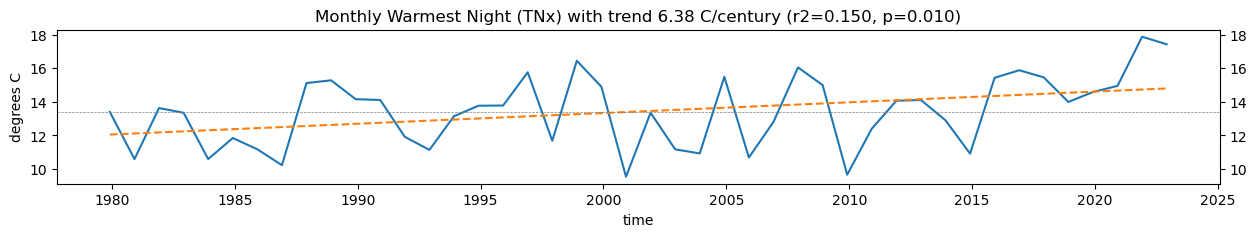

In [116]:
fig=plt.figure(figsize=(15,2))
TNx_DJF.plot()
regline_DJF.plot(linestyle='--')
plt.axhline(y=TNx_DJF.mean(),color='grey',linestyle='dashed',linewidth=0.5)
plt.tick_params(labelright=True, right=True)
plt.ylabel('degrees C')
plt.title(f'Monthly Warmest Night (TNx) with trend {trend_DJF:.2f} C/century (r2={reg_info_DJF.rvalue**2:.3f}, p={reg_info_DJF.pvalue:.3f})')
plt.show()


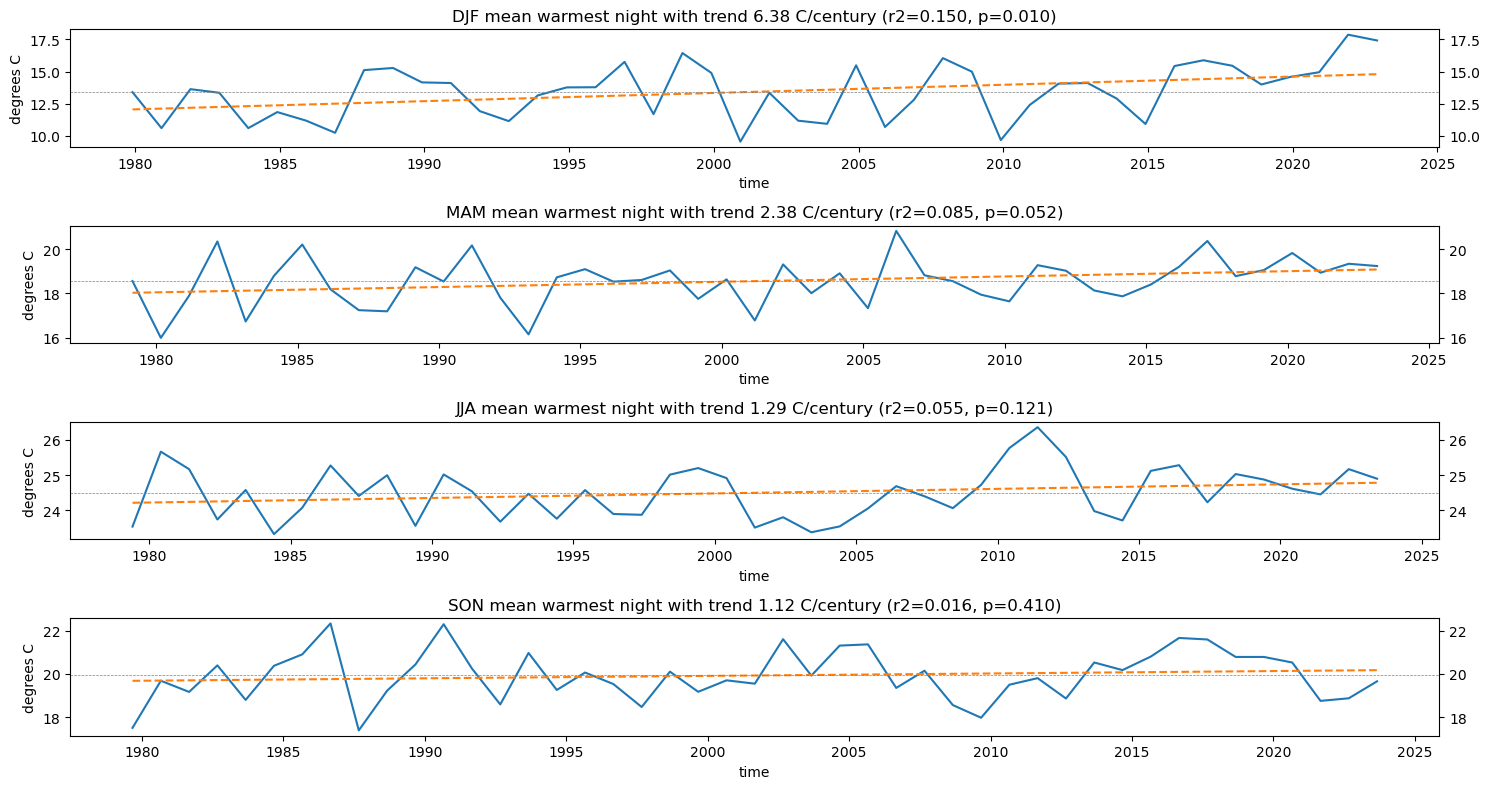

In [117]:
# do the same thing, but for each season using a loop

season_labels=['DJF','MAM','JJA','SON']
fig=plt.figure(figsize=(15,8))

for i,season in enumerate(season_labels):
    timeseries=TNx_seasonal[i::4] # sub select to a single season

    # drop first and last index if winter
    if season=='DJF':
        timeseries=timeseries[1:-1]

    # linear regression
    reg_info_season=ss.linregress(timeseries.time.dt.year,timeseries)
    trend_season=reg_info_season.slope*100 # C/season --> C/century  
    regline_season=reg_info_season.slope*timeseries.time.dt.year +reg_info_season.intercept

    # plot
    fig.add_subplot(4,1,i+1)
    timeseries.plot()
    regline_season.plot(linestyle='--')
    plt.axhline(y=timeseries.mean(),color='grey',linestyle='dashed',linewidth=0.5)  # a horizontal reference line
    plt.tick_params(labelright=True, right=True)
    plt.ylabel('degrees C')
    plt.title(f'{season} mean warmest night with trend {trend_season:.2f} C/century (r2={reg_info_season.rvalue**2:.3f}, p={reg_info_season.pvalue:.3f})')
    
plt.tight_layout()
plt.show()

Breaking TNx down seasonally, we can see statistically significant warming trends in winter (99% confidence) and spring (~95% condfidence) warmest nights, whereas the trends in summer and fall would not be considered statistically significant.

Let's check our winter result against maps provided by **[climdex.org](https://www.climdex.org/access/)**. What is different between what we calculated and what is available at climdex.org? Can we compare our results to these maps? 

Winter 45-year trends
<table><tr>
<td> <img src="figs/BEST (Berkeley Earth Surface Temperature) 1880-2019_TNx_DEC_TrendMap_1975-2019_24to51_-125to-65.png" alt="Drawing" width="400"/> </td>
<td> <img src="figs/BEST (Berkeley Earth Surface Temperature) 1880-2019_TNx_JAN_TrendMap_1975-2019_24to51_-125to-65.png" alt="Drawing" width="400"/> </td>
<td> <img src="figs/BEST (Berkeley Earth Surface Temperature) 1880-2019_TNx_FEB_TrendMap_1975-2019_24to51_-125to-65.png" alt="Drawing" width="400"/> </td>
</tr></table>

Let's look at 100-yr TNx trends for Dec, Jan, Feb. What is different between the climdex.org trends above calculated over the 45-year period vs the 100-year period 1920-2019 below?

Winter 100-year trends
<table><tr>
<td> <img src="figs/longterm/BEST (Berkeley Earth Surface Temperature) 1880-2019_TNx_DEC_TrendMap_1920-2019_24to51_-125to-65.png" alt="Drawing" width="400"/> </td>
<td> <img src="figs/longterm/BEST (Berkeley Earth Surface Temperature) 1880-2019_TNx_JAN_TrendMap_1920-2019_24to51_-125to-65.png" alt="Drawing" width="400"/> </td>
<td> <img src="figs/longterm/BEST (Berkeley Earth Surface Temperature) 1880-2019_TNx_FEB_TrendMap_1920-2019_24to51_-125to-65.png" alt="Drawing" width="400"/> </td>
</tr></table>

### Monthly Maximum Consecutive 5-day Precipitation (Rx5day)

In [ ]:
# remind ourselves what Rx5day looks like
Rx5day

In [ ]:
# you can't supply datetimes as the x values to a linear regression function
# if you use datetimes, you probably won't get an error but you'll get incorrect results
# instead of datetimes, supply integers or floats
# here we'll make a new coordinate of integer values from 0 to 539
Rx5day.coords['index']=('time',range(len(Rx5day.time)))
Rx5day

In [ ]:
# linear regression
reg_info=ss.linregress(Rx5day.index,Rx5day)

# convert units
trend=reg_info.slope*12*100 # mm/year --> mm/century

# create trend line for plotting
regline=reg_info.slope*Rx5day.index +reg_info.intercept

In [ ]:
# plot the linear regression over the timeseries TNx
fig=plt.figure(figsize=(15,2))
Rx5day.plot()
regline.plot(linestyle='--')
plt.axhline(y=Rx5day.mean(),color='grey',linestyle='dashed',linewidth=0.5)  # a horizontal reference line
plt.tick_params(labelright=True, right=True)
plt.ylabel('mm')
plt.title(f'monthly maximum consecutive 5-day precip with trend {trend:.2f} mm/century (r2={reg_info.rvalue**2:.3f}, p={reg_info.pvalue:.3f})')
plt.show()

The figure above shows that the increasing trend of 1.11 mm/century in Rx5day is meaningless because the trend is not statistically significant.

Let's check our result against a map provided by **[climdex.org](https://www.climdex.org/access/)**. What is different about the information provided on this map vs our analysis? Is Rx5day near Starkville similar? What areas of CONUS have significant Rx5day trends?

<img src="figs/REGEN-LONG V1 2019 masked_Rx5day_ANN_TrendMap_1972-2016_24to51_-125to-65.png"/>

Let's see if there is a statistically significant trend in for any particular month

In [ ]:
# similar to how we looped through seasons for TNx, but here we use months not seasons

month_labels=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
fig=plt.figure(figsize=(15,15))

for i,month in enumerate(month_labels):
    timeseries=Rx5day[i::12] # sub select based on month

    # linear regression
    reg_info_season=ss.linregress(timeseries.time.dt.year,timeseries)
    trend_season=reg_info_season.slope*100 # mm/year --> mm/century 
    regline_season=reg_info_season.slope*timeseries.time.dt.year +reg_info_season.intercept

    # plot
    fig.add_subplot(12,1,i+1)
    timeseries.plot()
    regline_season.plot(linestyle='--')
    plt.axhline(y=timeseries.mean(),color='grey',linestyle='dashed',linewidth=0.5)  # a horizontal reference line
    plt.tick_params(labelright=True, right=True)
    plt.ylabel('mm')
    plt.title(f'{month} maximum consecutive 5-day precip with trend {trend_season:.2f} mm/century (r2={reg_info_season.rvalue**2:.3f}, p={reg_info_season.pvalue:.3f})')
    
plt.tight_layout()
plt.show()

If we are looking for a trend that is significant at the 90% confidence level, we can see only June and November have p < 0.1, but even those months don't look robust trends. 

One quick test of robustness we can run is to hold out one or more data points at the start or end of the timeseries. If removal of a data point at one or both ends of the June and November timeseries changes p to greater than 0.1, then we can consider these trends to be not statistically significant.

In [ ]:
month_labels=['JUN','NOV']
month_ind=[5,10]
fig=plt.figure(figsize=(15,4))

for i,(m_ind,month) in enumerate(zip(month_ind,month_labels)):
    timeseries=Rx5day[i::12] # sub select based on month
    timeseries=timeseries[1:-1] # remove the first and last data point

    # linear regression
    reg_info_season=ss.linregress(timeseries.time.dt.year,timeseries)
    trend_season=reg_info_season.slope*100 # mm --> mm/century 
    regline_season=reg_info_season.slope*timeseries.time.dt.year +reg_info_season.intercept

    # plot
    fig.add_subplot(2,1,i+1)
    timeseries.plot()
    regline_season.plot(linestyle='--')
    plt.axhline(y=timeseries.mean(),color='grey',linestyle='dashed',linewidth=0.5)  # a horizontal reference line
    plt.tick_params(labelright=True, right=True)
    plt.ylabel('mm')
    plt.title(f'{month} maximum consecutive 5-day precip with trend {trend_season:.2f} mm/century (r2={reg_info_season.rvalue**2:.3f}, p={reg_info_season.pvalue:.3f})')
    
plt.tight_layout()
plt.show()

We can conclude that there are no statistically significant trends in Rx5day or in the Rx5day timeseries for any particular month.

Let's check our result against maps provided by **[climdex.org](https://www.climdex.org/access/)**. What is different about the information provided on this map vs our analysis? Is June or November Rx5day near Starkville similar? What areas of CONUS have significant June and November Rx5day trends?

<table><tr>
<td> <img src="figs/REGEN-LONG V1 2019 masked_Rx5day_JUN_TrendMap_1972-2016_24to51_-125to-65.png" alt="Drawing" width="600"/> </td>
<td> <img src="figs/REGEN-LONG V1 2019 masked_Rx5day_NOV_TrendMap_1972-2016_24to51_-125to-65.png" alt="Drawing" width="600"/> </td>
</tr></table>

# Your Turn!

**Choose one of three mini-projects below to complete on your own and prepare to share your findings**


## Option 1 (easiest)
Calculate the monthly mean daily temperature range (DTR) at Starkville, determine whether there is a statistically significant trend, and create a figure showing the DTR timeseries, linear trend, and p value. Compare your results to climdex.org, looking at the trend in DTR over CONUS for similar data years (1977-2021) and also for data years 1922-2021 from the Berkeley Earth Surface Temperature dataset. 

&emsp;Hints:
- Use daily tmax and tmin data
- Apply the relevant steps from the data cleaning section (drop leap days)
- Calculate the daily temperature range as tmax-tmin
- For each month, find the mean daily temperature range
- Determine if there is a statistically significant trend in DTR at the 90% confidence level
- Plot the DTR timeseries with its linear trend line. Your plot should have x axis tick labels as years, a y axis label that describes the units, and a title that includes the p value.
- Go to **[climdex.org](https://www.climdex.org/access/)** and get the png of DTR trend over CONUS using data years 1977-2021 from the BEST dataset
- Go to **[climdex.org](https://www.climdex.org/access/)** and get the png of DTR trend over CONUS using data years 1922-2021 from the BEST dataset

![cci_option1_figure.png](figs/cci_option1_figure.png)

## Option 2 (moderate)
Modify the TNx analysis to operate on gridded data (3-dimensional instead of the 1-dimensional data used in this notebook), performing all calculations at each grid cell. Include the relevant parts of the data cleaning section, calculate TNx, and then calculate the January TNx trend and pvalue. Present your results in a figure that shows the January TNx trend in C/year for each grid cell on a map if it is statistically significant at the 95% confidence level. Compare your results to climdex.org, looking at the trend in Jan TNx over CONUS for similar data years (1975-2019) and also for data years 1920-2019 from the Berkeley Earth Surface Temperature dataset.

&emsp;Hints:
- Use gridded tmin data for Mississippi from the file tmin_AgERA5_Mississippi_Daily_1979-2023.nc
- For data cleaning, do the steps that apply to tn only
    - nan for daily temperature greater than 70C or less than -70C
    - remove leap days
    - daily temperature outliers (5x std)
    - you may also want to use the function get_nans_per_month to plot the maximum number of nans per month found at each grid cell
- To use scipy.stats.linregress with multidimensional data, use **[xr.stack](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.stack.html)** and a for loop or use nested for loops. Alternatively, write your own function to vectorize calculation of linear trend and pvalue.
- Plot the map of Jan trend values with units C/year, but only show the trend at grid cells that are statistically significant at the 95% confidence level or greater (use the p value and **[xarray.DataArray.where](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.where.html)** to mask out insignificant trends)
- Draw state boundaries on your map with cartopy (import cartopy.crs as ccrs, import cartopy.feature as cf) or use a different method/package of your choice
- Go to **[climdex.org](https://www.climdex.org/access/)** and get the png of Jan TNx trend over CONUS using data years 1975-2019 from the BEST dataset
- Go to **[climdex.org](https://www.climdex.org/access/)** and get the png of Jan TNx trend over CONUS using data years 1920-2019 from the BEST dataset

![cci_option2_figure.png](figs/cci_option2_figure.png)

## Option 3 (moderate, longest)
Calculate the warm spell duration index (WSDI) at Starkville, determine whether there is a statistically significant trend, and create a figure showing the WSDI timeseries, linear trend, and p value. Compare your results to climdex.org, looking at the trend in WSDI over CONUS for similar data years (1977-2021) and also for data years 1922-2021 from the Berkeley Earth Surface Temperature dataset.

&emsp;Hints:
- Use daily tmax data but drop leap days entirely
- Calculate WSDI using the following criteria
    - 6 consecutive days of hot maximum temperatures
    - hot temperature threshold defined as > 90th percentile of tx for each calendar day using a centered 5-day window in the base period 1981-2010
    - warm spells that contain dates over multiple years are assigned to the year when the spell ends
- Determine if there is a statistically significant trend in DTR at the 90% confidence level
- Plot the DTR timeseries with its linear trend line. Your plot should have x axis tick labels as years, a y axis label that describes the units, and a title that includes the p value.
- Go to **[climdex.org](https://www.climdex.org/access/)** and get the png of WSDI trend over CONUS using data years 1977-2021 from the BEST dataset
- Go to **[climdex.org](https://www.climdex.org/access/)** and get the png of WSDI trend over CONUS using data years 1922-2021 from the BEST dataset

![cci_option3_figure.png](figs/cci_option3_figure.png)


<details>
    <summary><font color="blue"><b>...</b></font></summary>
  
#### Option 1 Answer Key
[climate_change_indicators_option1.ipynb](https://github.com/kerriegeil/MSU_py_training/blob/main/learn_by_doing/climate_change_indicators/assignments/climate_change_indicators_option1.ipynb)

#### Option 2 Answer Key
[climate_change_indicators_option2.ipynb](https://github.com/kerriegeil/MSU_py_training/blob/main/learn_by_doing/climate_change_indicators/assignments/climate_change_indicators_option2.ipynb)

#### Option 3 Answer Key
[climate_change_indicators_option3.ipynb](https://github.com/kerriegeil/MSU_py_training/blob/main/learn_by_doing/climate_change_indicators/assignments/climate_change_indicators_option3.ipynb)
</details>